In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
from pandas_datareader import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Ensure you have the latest version of yfinance

from datetime import datetime


In [45]:
def plot_train_val_loss(history):
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def plot_prediction(y_true, y_pred, title='Prediction'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.title(title)
    plt.ylabel('Close')
    plt.xlabel('time')
    plt.legend()
    plt.show()

def evaluate_model(model, X_train, y_train, X_val, y_val, scaler_target_train_val, title_plot = 'Validation Prediction'):
    plt.figure(figsize=(14, 5))
    y_train_pred = model.predict(X_train)
    y_train_pred = scaler_target_train_val.inverse_transform(y_train_pred)
    y_train = scaler_target_train_val.inverse_transform(y_train.reshape(-1, 1))
    y_val_pred = model.predict(X_val)
    y_val_pred = scaler_target_train_val.inverse_transform(y_val_pred)
    y_val = scaler_target_train_val.inverse_transform(y_val.reshape(-1, 1))
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    print(f'Train RMSE: {train_rmse}')
    print(f'Val RMSE: {val_rmse}')
    print(f'Train MSE: {train_mse}')
    print(f'Val MSE: {val_mse}')
    print(f'Train R2: {r2_train}')
    print(f'Val R2: {r2_val}')
    
    
    plot_prediction(y_val, y_val_pred, title=title_plot)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


# APPLE STOCK EXPERIMENT

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447412  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458559  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355827  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344077  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386257  7.570714  7.571429  7.466429  7.510714  447610800


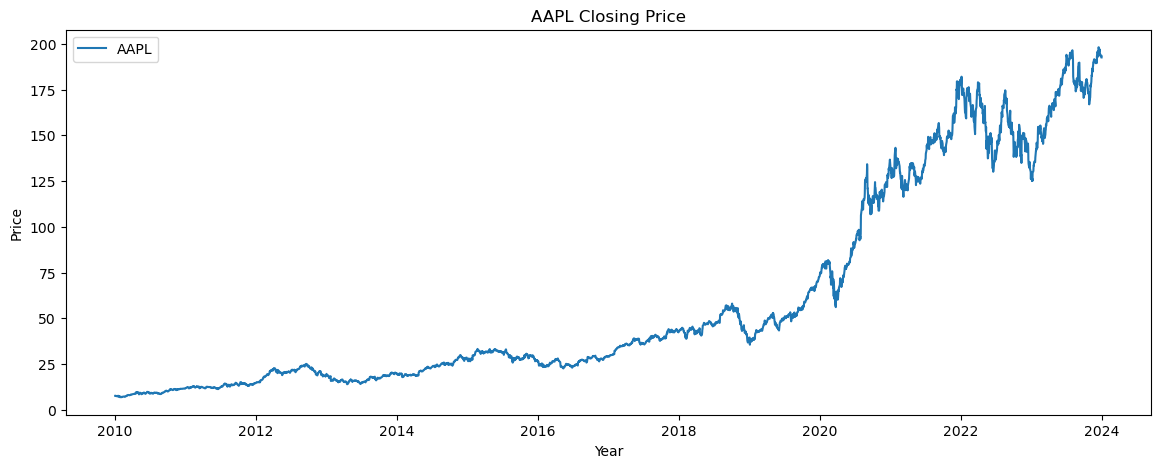

In [98]:
# Function to download stock price data
def download_stock_data(ticker, start_date, end_date, interval='1d'):
    """
    Download historical stock price data from Yahoo Finance.

    :param ticker: Stock ticker symbol (e.g., 'AAPL', 'GOOG').
    :param start_date: Start date for data in format 'YYYY-MM-DD'.
    :param end_date: End date for data in format 'YYYY-MM-DD'.
    :param interval: Data interval ('1d', '1wk', '1mo', etc.).
    :return: Pandas DataFrame with stock price data.
    """
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

# Example usage
ticker = 'AAPL'  # Replace with your desired stock ticker
start_date = '2010-01-01'
end_date = '2023-12-31'

# Download the data
apple_data = download_stock_data(ticker, start_date, end_date)

# Save to CSV (optional)
apple_data.to_csv(f'{ticker}_stock_data.csv')

# Display the first few rows
print(apple_data.head())

# Plot the closing price
plt.figure(figsize=(14, 5))
plt.plot(apple_data['Close'], label='AAPL')
plt.title('AAPL Closing Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend() 
plt.show()


In [99]:
apple_data.describe()

Price     Adj Close        Close         High          Low         Open  \
Ticker         AAPL         AAPL         AAPL         AAPL         AAPL   
count   3522.000000  3522.000000  3522.000000  3522.000000  3522.000000   
mean      57.637984    59.926226    60.528731    59.267621    59.883701   
std       55.581155    55.444533    56.014467    54.812449    55.387520   
min        5.785830     6.858929     7.000000     6.794643     6.870357   
25%       16.967525    19.608571    19.832321    19.402321    19.680447   
50%       29.071424    32.340000    32.633751    32.078751    32.303749   
75%       88.873848    91.207499    92.512501    90.425623    91.213125   
max      197.144180   198.110001   199.619995   197.000000   198.020004   

Price         Volume  
Ticker          AAPL  
count   3.522000e+03  
mean    2.422834e+08  
std     2.204578e+08  
min     2.404830e+07  
25%     9.266760e+07  
50%     1.526602e+08  
75%     3.284715e+08  
max     1.880998e+09

## Baseline Model

/var/folders/rc/fk61m8cs3sv6b0k2cvf5h3tr0000gn/T/ipykernel_26276/2239757756.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return predictions.fillna(method='bfill')


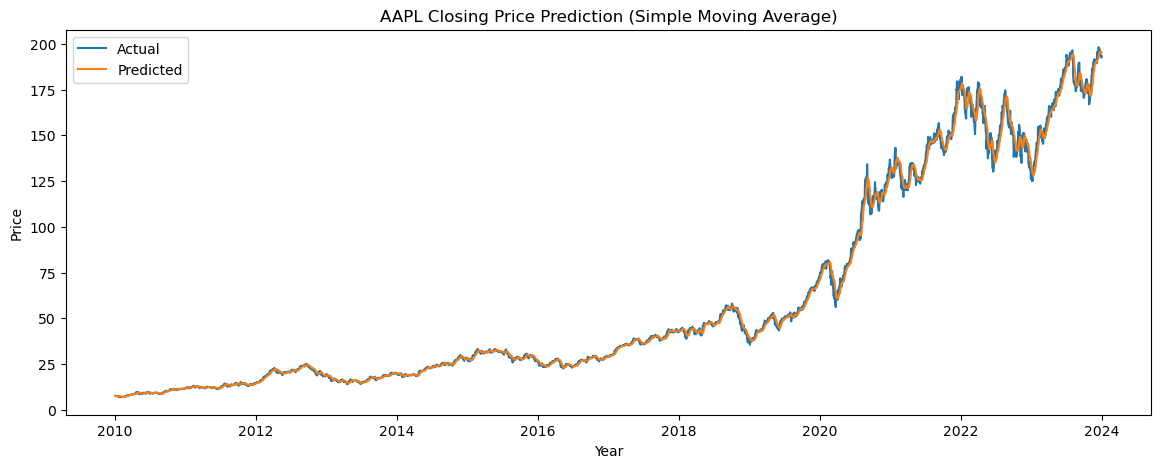

Mean Squared Error: 7.61
Mean Absolute Percentage Error (MAPE): 2.62%


In [100]:
def moving_average_prediction_from_dataframe(dataframe, column_name, window_size):
    """
    Predict stock price using a simple moving average.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing stock price data.
        column_name (str): The name of the column to use for prediction (e.g., 'Close').
        window_size (int): The window size for calculating the moving average.

    Returns:
        pd.Series: Series of predicted values.
    """
    # Ensure the specified column exists
    if column_name not in dataframe.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Extract the target column and calculate the rolling average
    data = dataframe[column_name]
    moving_averages = data.rolling(window=window_size).mean()

    # Shift the moving averages forward by one to make predictions
    predictions = moving_averages.shift(1)

    # Fill NaN values and return the predictions
    return predictions.fillna(method='bfill')


# Predict using a simple moving average
window_size = 10
predictions = moving_average_prediction_from_dataframe(apple_data, 'Close', window_size)

# Plot the actual and predicted values
plt.figure(figsize=(14, 5))
plt.plot(apple_data['Close'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('AAPL Closing Price Prediction (Simple Moving Average)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate the mean squared error MAPE
mse = mean_squared_error(apple_data['Close'], predictions)
mape = np.mean(np.abs((apple_data['Close'] - predictions) / apple_data['Close'])) * 100
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')



/var/folders/rc/fk61m8cs3sv6b0k2cvf5h3tr0000gn/T/ipykernel_26276/2697136893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_30_percent[column_name] = last_30_percent['Close'].rolling(ma).mean()
/var/folders/rc/fk61m8cs3sv6b0k2cvf5h3tr0000gn/T/ipykernel_26276/2697136893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_30_percent[column_name] = last_30_percent['Close'].rolling(ma).mean()
/var/folders/rc/fk61m8cs3sv6b0k2cvf5h3tr0000gn/T/ipykernel_26276/2697136893.py:11: SettingWithCopyWarnin

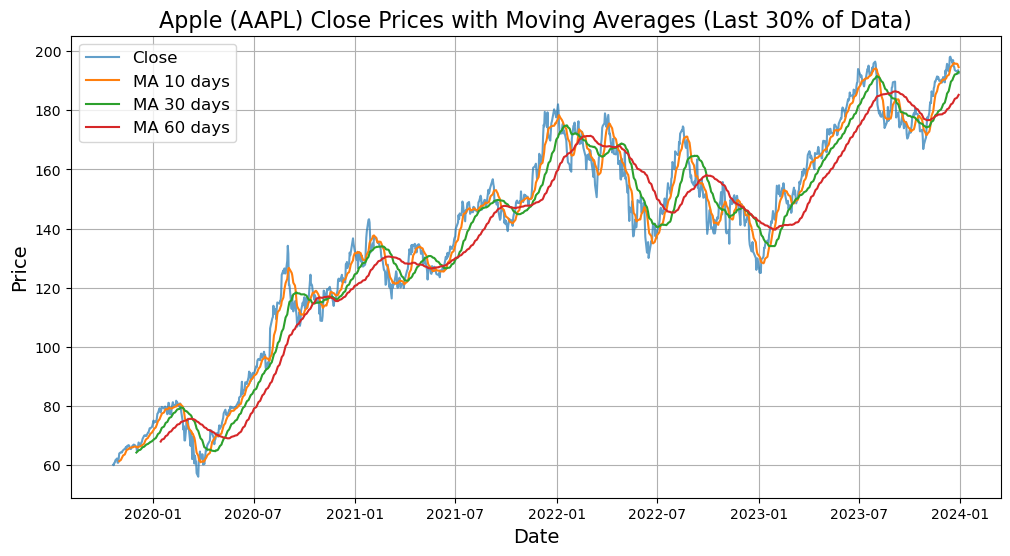

In [167]:
# Moving average days
AAPL = apple_data.copy()
ma_day = [10, 30, 60]

# Select the last 30% of the data
last_30_percent = AAPL[-int(len(AAPL) * 0.3):]

# Calculate moving averages for Apple on the last 30% of the data
for ma in ma_day:
    column_name = f"MA for {ma} days"
    last_30_percent[column_name] = last_30_percent['Close'].rolling(ma).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(last_30_percent['Close'], label='Close', alpha=0.7, linewidth=1.5)
for ma in ma_day:
    plt.plot(last_30_percent[f"MA for {ma} days"], label=f"MA {ma} days", linewidth=1.5)

plt.title('Apple (AAPL) Close Prices with Moving Averages (Last 30% of Data)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [198]:
# Calculate RMSE for SMA
close_prices = apple_data['Close']

# Define the split for the last 30% of the data
split_index = int(len(close_prices) * 0.7)
last_30_percent = close_prices[split_index:]

# Calculate simple moving averages (SMA) and RMSE
window_sizes = [10, 30, 60]
rmse_values = {}

for window_size in window_sizes:
    sma = last_30_percent.rolling(window=window_size).mean()
    # Align SMA with actual values (drop NaNs)
    valid_actual = last_30_percent[window_size - 1:]
    valid_sma = sma[window_size - 1:]
    
    # Calculate RMSE
    rmse = mean_squared_error(valid_actual, valid_sma)
    rmse_values[window_size] = rmse

# Output RMSE values
print(rmse_values)

{10: 17.439857993067807, 30: 59.48581029529479, 60: 118.30998684989036}


## RNN

In [110]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def load_stock_data_close(data, sequence_length, test_size, val_size):
    # Convert the DataFrame to a NumPy array
    data = data['Close'].values
    data = data.reshape(-1, 1)  # Reshape to a single feature (column)

    # Split the data into training, validation, and test sets
    train_size = len(data) - int(len(data) * (test_size + val_size))
    val_size = len(data) - int(len(data) * test_size)
    train_data, val_data, test_data = data[:train_size], data[train_size:val_size], data[val_size:]

    # Normalize the data
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    test_data = scaler.transform(test_data)

    # Create sequences of data
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_val, y_val = create_sequences(val_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

X_train, y_train, X_val, y_val, X_test, y_test, scaler = load_stock_data_close(apple_data, sequence_length=20, test_size=0.1, val_size=0.1)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2798, 20, 1) (2798, 1) (332, 20, 1) (332, 1) (332, 20, 1) (332, 1)


In [138]:
y_train[0:5]

array([0.00602395, 0.00515665, 0.00419763, 0.00149354, 0.00288751])

In [73]:
def build_rnn_model(input_shape):
    model = Sequential([
        Input(input_shape),  # Use input_shape directly as a positional argument
        SimpleRNN(units=32, activation='tanh', return_sequences=False),
        Dense(units=1)  # Output layer for the close price prediction
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Assuming X_train is prepared and has the shape (num_samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
vanilla_rnn_uni = build_rnn_model(input_shape)
vanilla_rnn_uni.summary()

history_vanilla_rnn = vanilla_rnn_uni.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [6]:
def load_stock_data(data, sequence_length=10, test_size=0.2, val_size=0.1):
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np

    # Ensure the necessary columns are present
    required_columns = ['Low', 'High', 'Open', 'Close', 'Volume']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Dataset must contain the following columns: {required_columns}")

    # Split into train-validation and test sets
    total_size = len(data)
    test_split = int(total_size * (1 - test_size))
    val_split = int(test_split * (1 - val_size))
    
    train_val_data = data.iloc[:test_split]
    test_data = data.iloc[test_split:]

    # Separate scalers for train-validation and test
    scaler_features_train_val = MinMaxScaler(feature_range=(0, 1))
    scaler_target_train_val = MinMaxScaler(feature_range=(0, 1))
    scaler_features_test = MinMaxScaler(feature_range=(0, 1))
    scaler_target_test = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform features for train-validation
    scaled_features_train_val = scaler_features_train_val.fit_transform(train_val_data[required_columns])
    scaled_target_train_val = scaler_target_train_val.fit_transform(train_val_data[['Close']])

    # Fit and transform features for test
    scaled_features_test = scaler_features_test.fit_transform(test_data[required_columns])
    scaled_target_test = scaler_target_test.fit_transform(test_data[['Close']])

    # Prepare sequences for train-validation
    X_train_val, y_train_val = [], []
    for i in range(len(scaled_features_train_val) - sequence_length):
        X_train_val.append(scaled_features_train_val[i:i + sequence_length, :])
        y_train_val.append(scaled_target_train_val[i + sequence_length, 0])  # Scaled Close as target

    X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)

    # Split train and validation
    X_train = X_train_val[:val_split]
    y_train = y_train_val[:val_split]
    X_val = X_train_val[val_split:]
    y_val = y_train_val[val_split:]

    # Prepare sequences for test
    X_test, y_test = [], []
    for i in range(len(scaled_features_test) - sequence_length):
        X_test.append(scaled_features_test[i:i + sequence_length, :])
        y_test.append(scaled_target_test[i + sequence_length, 0])  # Scaled Close as target

    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test

In [7]:
# Lookback size = 10
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)
print('X_train size', X_train.shape)
print('X_val size', X_val.shape)
print('X_test size', X_test.shape)
print('y_train size', y_train.shape)
print('y_val size', y_val.shape)
print('y_test size', y_test.shape)


X_train size (2535, 10, 5)
X_val size (272, 10, 5)
X_test size (695, 10, 5)
y_train size (2535,)
y_val size (272,)
y_test size (695,)


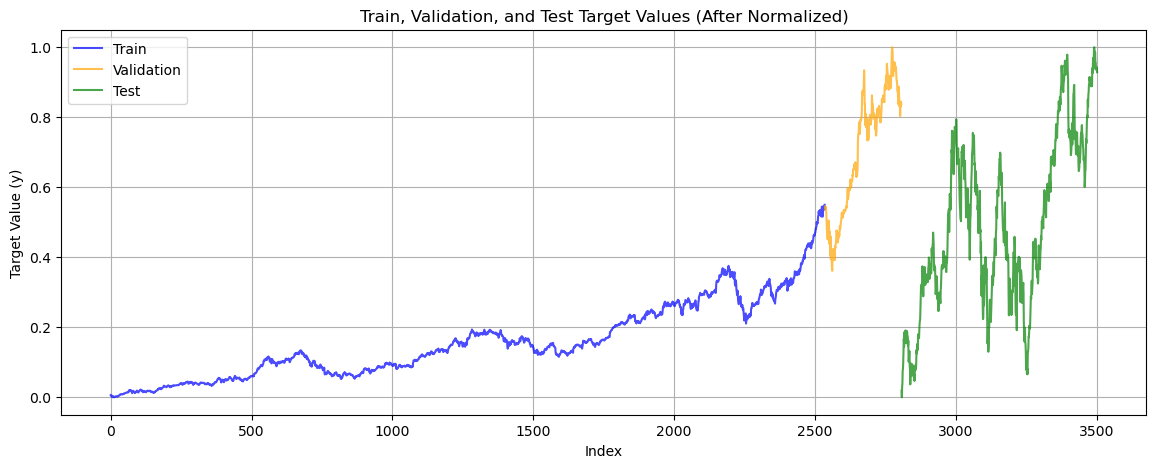

In [8]:
def plot_y_splits(y_train, y_val, y_test):
    """
    Plot y_train, y_val, and y_test on the same plot with different colors.

    Parameters:
        y_train (array-like): Training targets.
        y_val (array-like): Validation targets.
        y_test (array-like): Test targets.
    """
    plt.figure(figsize=(14, 5))
    
    # Plot each split
    plt.plot(range(len(y_train)), y_train, label='Train', color='blue', alpha=0.7)
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val, label='Validation', color='orange', alpha=0.7)
    plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, label='Test', color='green', alpha=0.7)
    
    # Add labels and legend
    plt.title('Train, Validation, and Test Target Values (After Normalized)')
    plt.xlabel('Index')
    plt.ylabel('Target Value (y)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_y_splits(y_train, y_val, y_test)

Vanila RNN (Unit 32, batch size 32, activation tanh)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


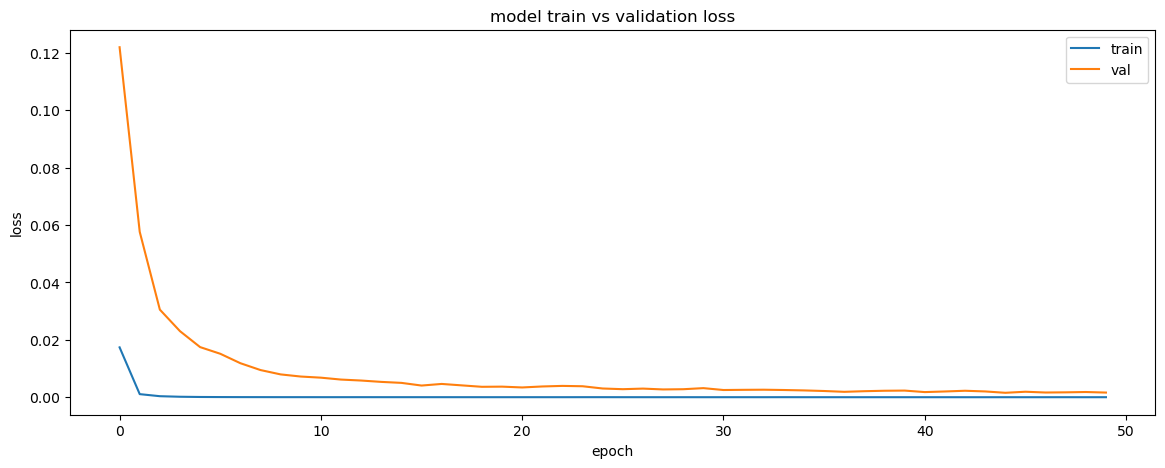

9/9 [==============================] - 0s 455us/step
Train MSE: 0.41973114245210724
Val MSE: 30.589898432644503


<Figure size 1400x500 with 0 Axes>

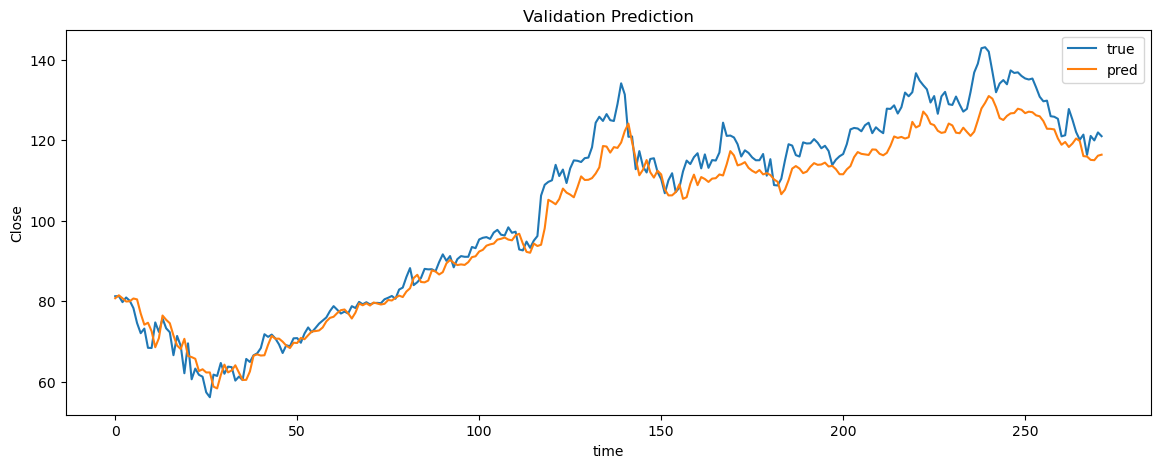

In [11]:
from tensorflow.keras.layers import Input

def build_rnn_model_32(input_shape):
    model = Sequential([
        Input(input_shape),  # Use input_shape directly as a positional argument
        SimpleRNN(units=32, activation='tanh', return_sequences=False),
        Dense(units=1)  # Output layer for the close price prediction
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Assuming X_train is prepared and has the shape (num_samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
vanilla_rnn = build_rnn_model_32(input_shape)
vanilla_rnn.summary()

history_vanilla_rnn = vanilla_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

plot_train_val_loss(history_vanilla_rnn)
evaluate_model(vanilla_rnn, X_train, y_train, X_val, y_val, scaler_target_train_val)

Vanila RNN (Unit 32, batch size 32, activation relu)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


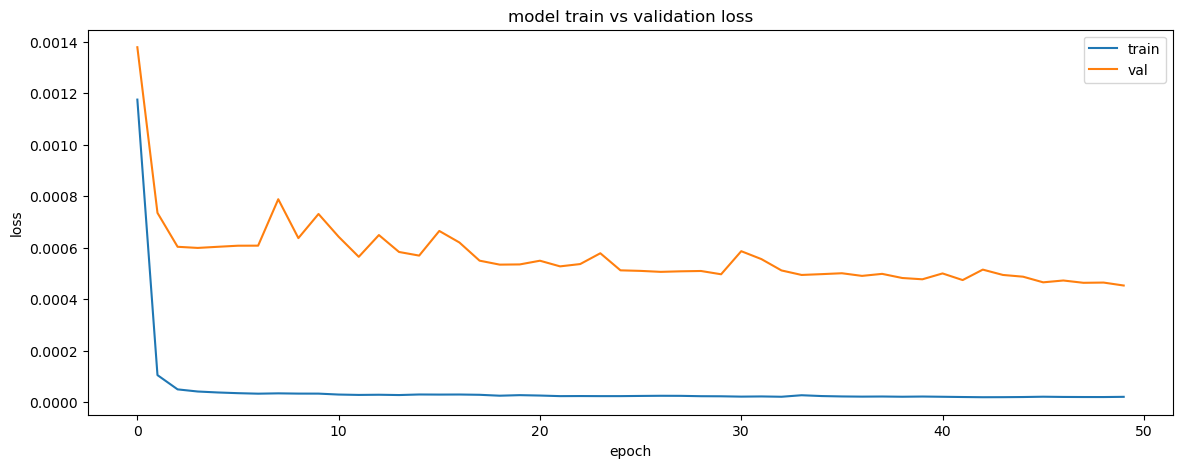

9/9 [==============================] - 0s 519us/step
Train MSE: 0.34836066316265313
Val MSE: 8.424922906617747


<Figure size 1400x500 with 0 Axes>

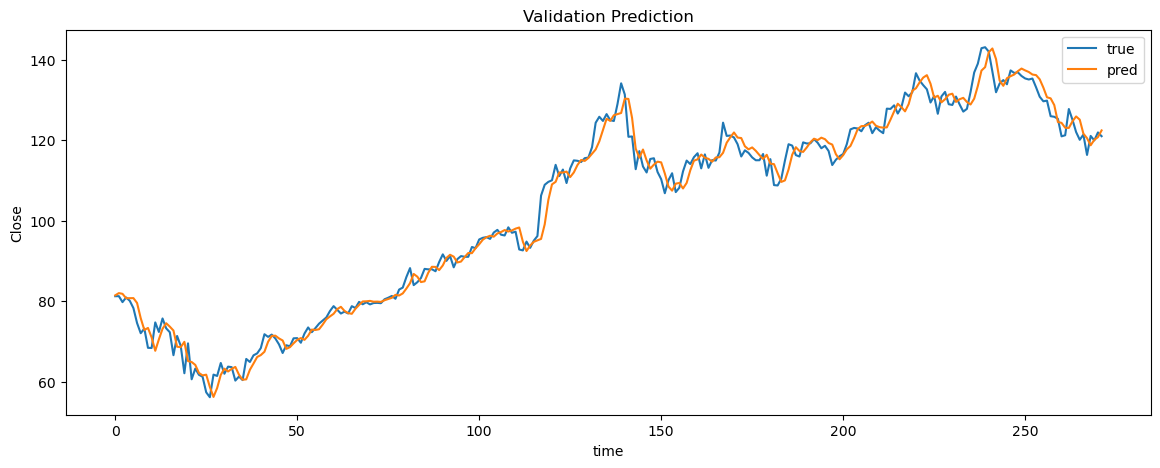

In [19]:
def build_rnn_model_relu_32(input_shape, learning_rate=0.001):
    model = Sequential([
        Input(input_shape),  # Use input_shape directly as a positional argument
        SimpleRNN(units=32, activation='relu', return_sequences=False),
        Dense(units=1)  # Output layer for the close price prediction
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Assuming X_train is prepared and has the shape (num_samples, sequence_length, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
vanilla_rnn_relu = build_rnn_model_relu_32(input_shape)
vanilla_rnn_relu.summary()

history_vanilla_rnn_relu = vanilla_rnn_relu.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_vanilla_rnn_relu)
evaluate_model(vanilla_rnn_relu, X_train, y_train, X_val, y_val, scaler_target_train_val)


Vanila RNN (Unit 64, batch size 32, activation relu)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 64)                4480      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


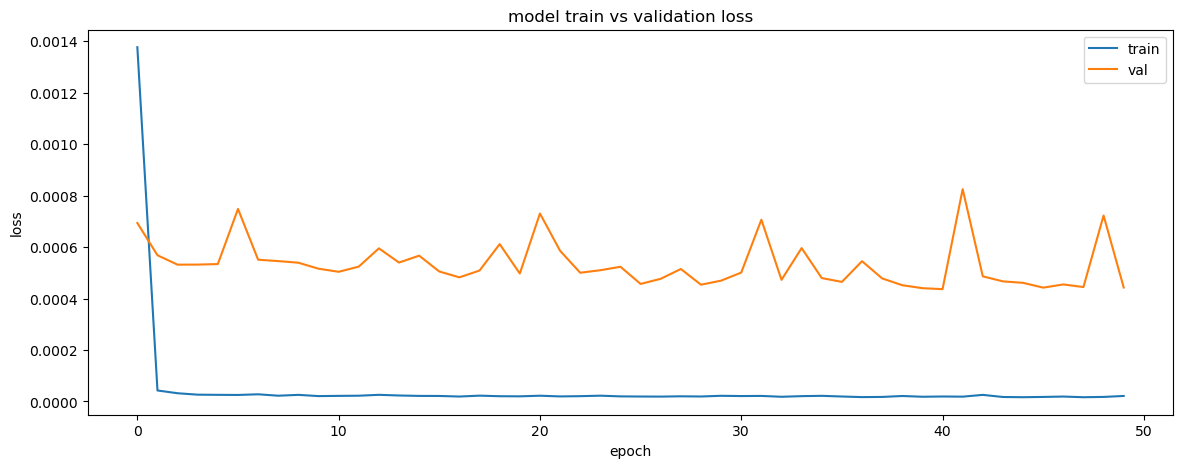

9/9 [==============================] - 0s 474us/step
Train MSE: 0.3721998784814374
Val MSE: 8.229605600921895


<Figure size 1400x500 with 0 Axes>

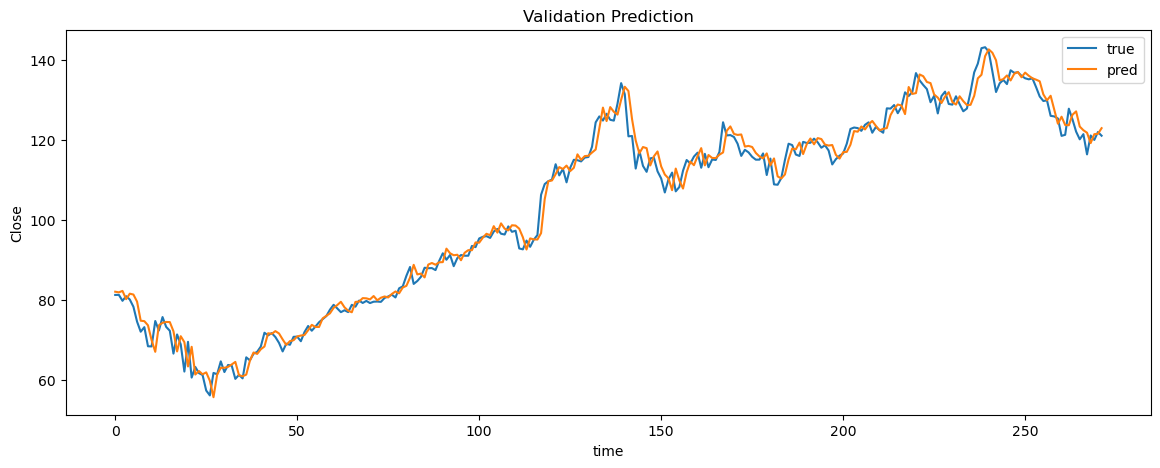

In [21]:
def build_rnn_model_relu_64(input_shape, learning_rate=0.001):
    model = Sequential([
        Input(input_shape),  # Use input_shape directly as a positional argument
        SimpleRNN(units=64, activation='relu', return_sequences=False),
        Dense(units=1)  # Output layer for the close price prediction
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

vanilla_rnn_relu_64 = build_rnn_model_relu_64(input_shape)
vanilla_rnn_relu_64.summary()

history_vanilla_rnn_relu_64 = vanilla_rnn_relu_64.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_vanilla_rnn_relu_64)
evaluate_model(vanilla_rnn_relu_64, X_train, y_train, X_val, y_val, scaler_target_train_val)


Vanila RNN (Unit 64, batch size 64, activation relu)

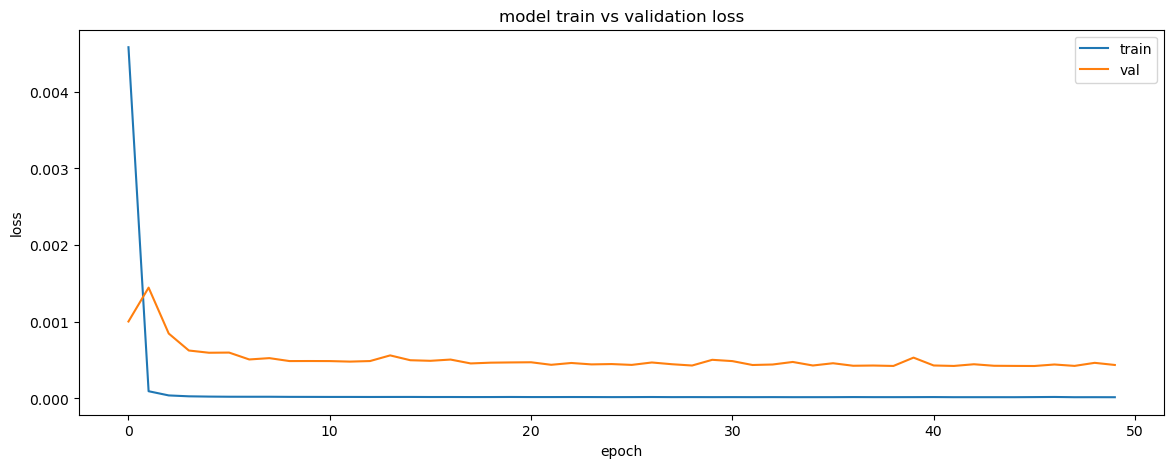

9/9 [==============================] - 0s 482us/step
Train MSE: 0.2737460260959717
Val MSE: 8.101356595802024


<Figure size 1400x500 with 0 Axes>

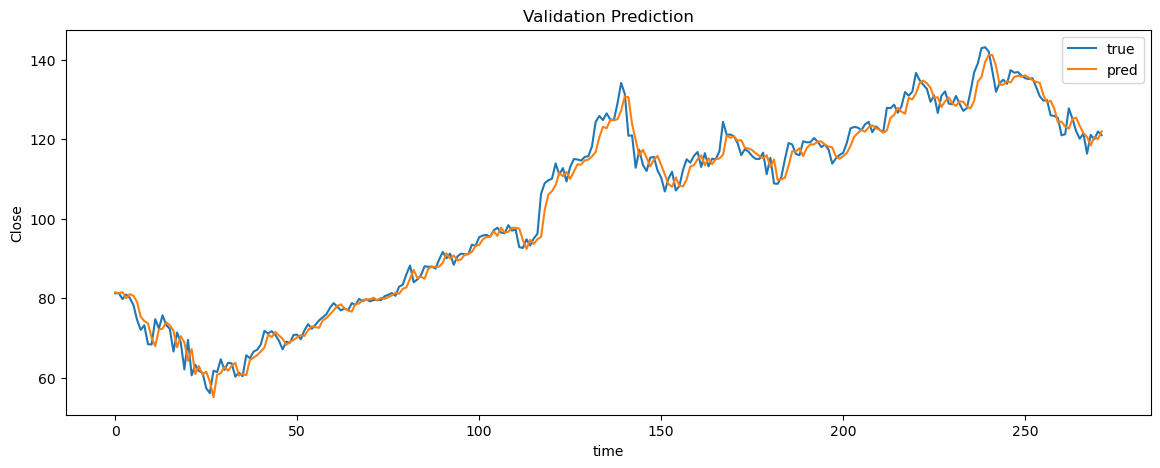

In [17]:
vanilla_rnn_relu_64_bs64 = build_rnn_model_relu_64(input_shape)
history_vanilla_rnn_relu_64_bs64 = vanilla_rnn_relu_64_bs64.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=0)
plot_train_val_loss(history_vanilla_rnn_relu_64_bs64)
evaluate_model(vanilla_rnn_relu_64_bs64, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 128)               17152     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


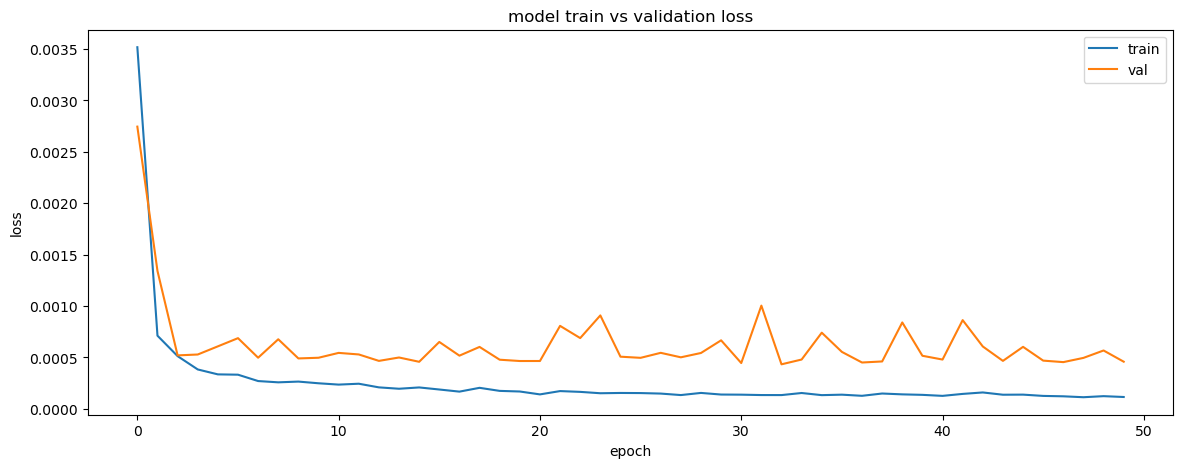

9/9 [==============================] - 0s 572us/step
Train MSE: 0.5042171883979583
Val MSE: 8.529213686474364


<Figure size 1400x500 with 0 Axes>

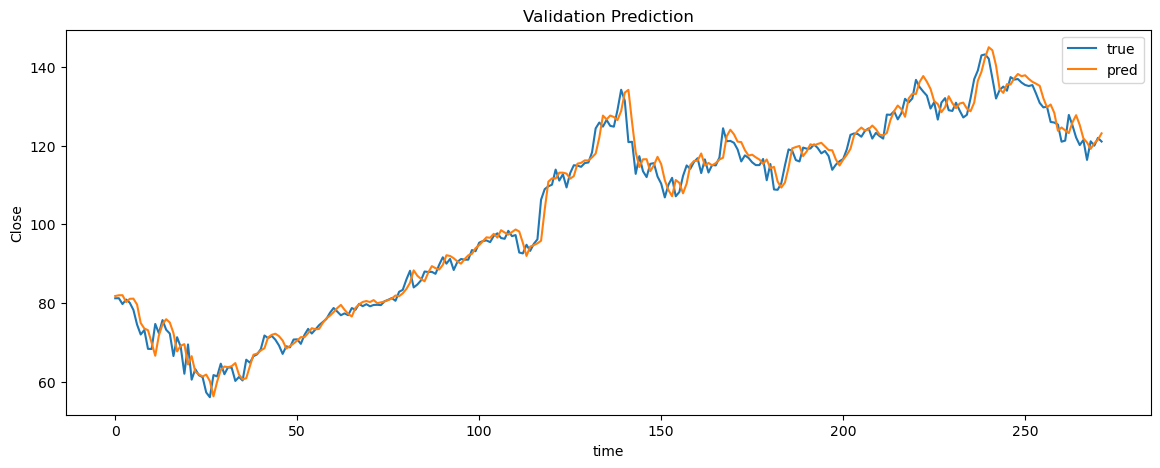

In [20]:
# build rnn model with 128 unit and dropout
def build_rnn_model_relu_128_dropout(input_shape, learning_rate=0.001):
    model = Sequential([
        Input(input_shape),  # Use input_shape directly as a positional argument
        SimpleRNN(units=128, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(units=1)  # Output layer for the close price prediction
    ])
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

vanilla_rnn_relu_128_dropout = build_rnn_model_relu_128_dropout(input_shape)
vanilla_rnn_relu_128_dropout.summary()

history_vanilla_rnn_relu_128_dropout = vanilla_rnn_relu_128_dropout.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_vanilla_rnn_relu_128_dropout)
evaluate_model(vanilla_rnn_relu_128_dropout, X_train, y_train, X_val, y_val, scaler_target_train_val)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 64)                4480      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


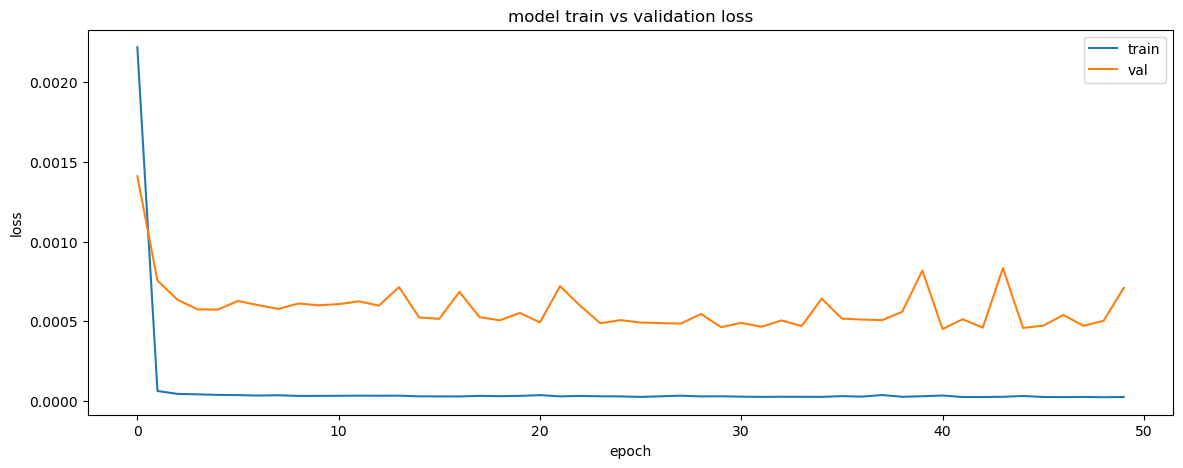

8/8 [==============================] - 0s 785us/step
Train MSE: 0.6926592095306773
Val MSE: 13.177442267243364


<Figure size 1400x500 with 0 Axes>

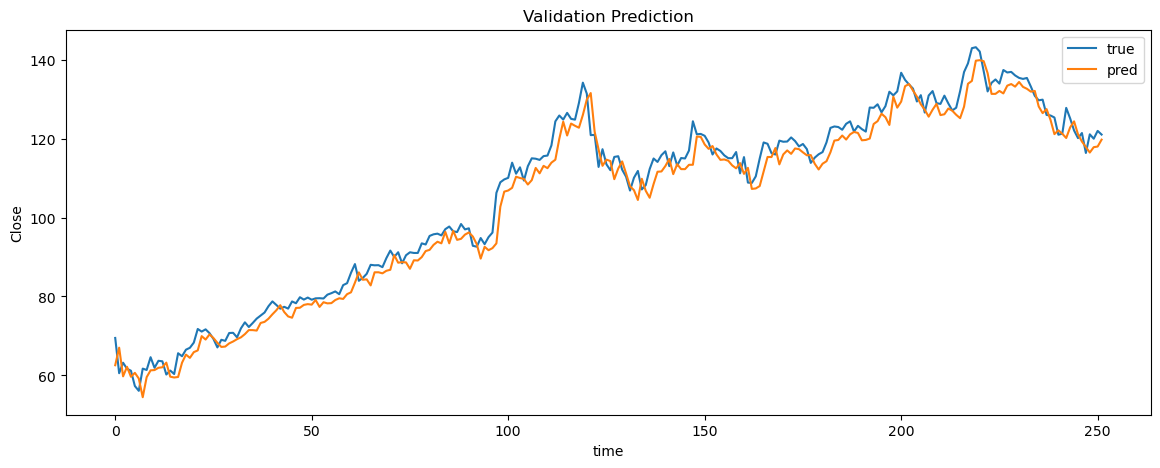

In [22]:
# Lookback size = 30
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=30, test_size=0.2, val_size=0.1)
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lookback_30 = build_rnn_model_relu_64(input_shape)
model_lookback_30.summary()

history_lookback_30 = model_lookback_30.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_lookback_30)
evaluate_model(model_lookback_30, X_train, y_train, X_val, y_val, scaler_target_train_val)




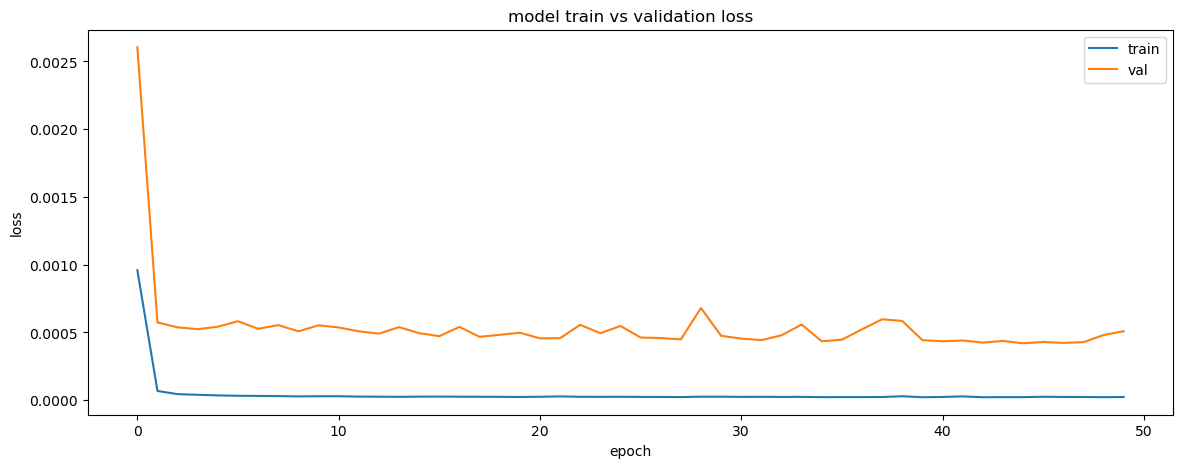

8/8 [==============================] - 0s 750us/step
Train MSE: 0.44930493962641643
Val MSE: 9.45750555096888


<Figure size 1400x500 with 0 Axes>

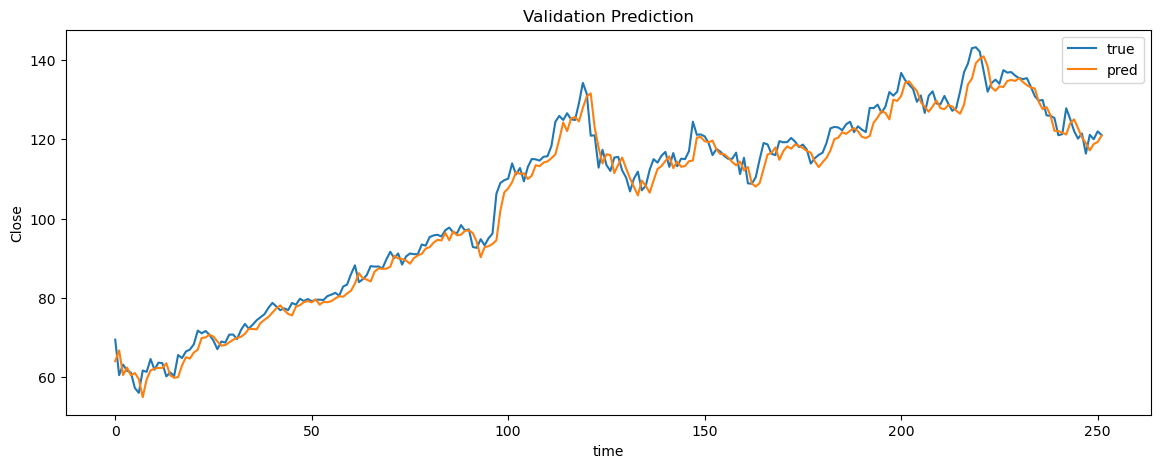

In [23]:
model_lookback_30_64_ii = build_rnn_model_relu_64(input_shape)
history_lookback_30_64_ii = model_lookback_30_64_ii.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=0)
plot_train_val_loss(history_lookback_30_64_ii)
evaluate_model(model_lookback_30_64_ii, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 64)                4480      
                                                                 
 dense_96 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


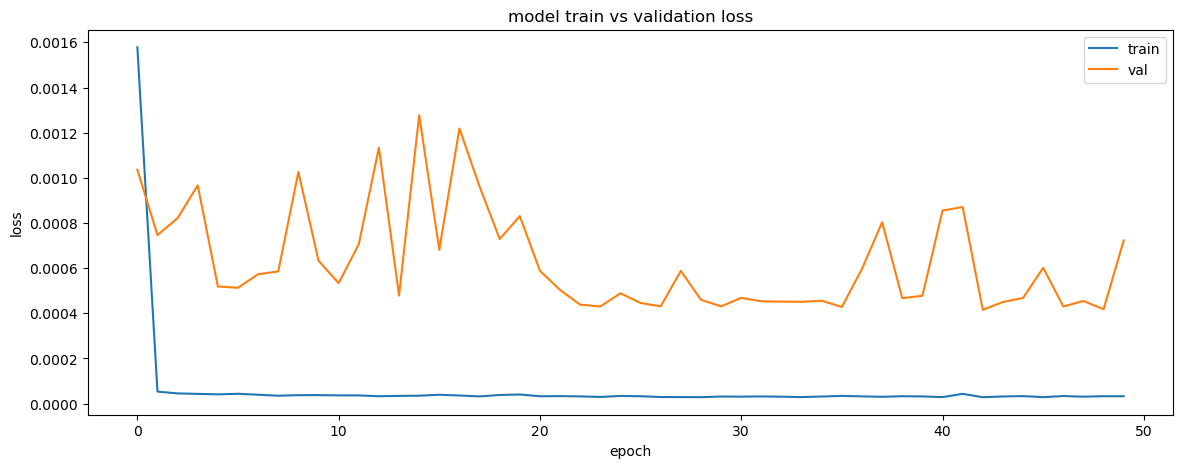

7/7 [==============================] - 0s 1ms/step
Train RMSE: 0.7978203393461729
Val RMSE: 3.6642332900303627
Train MSE: 0.6365172938744426
Val MSE: 13.426605603766737
Train R2: 0.997415096151815
Val R2: 0.9619899508375352


<Figure size 1400x500 with 0 Axes>

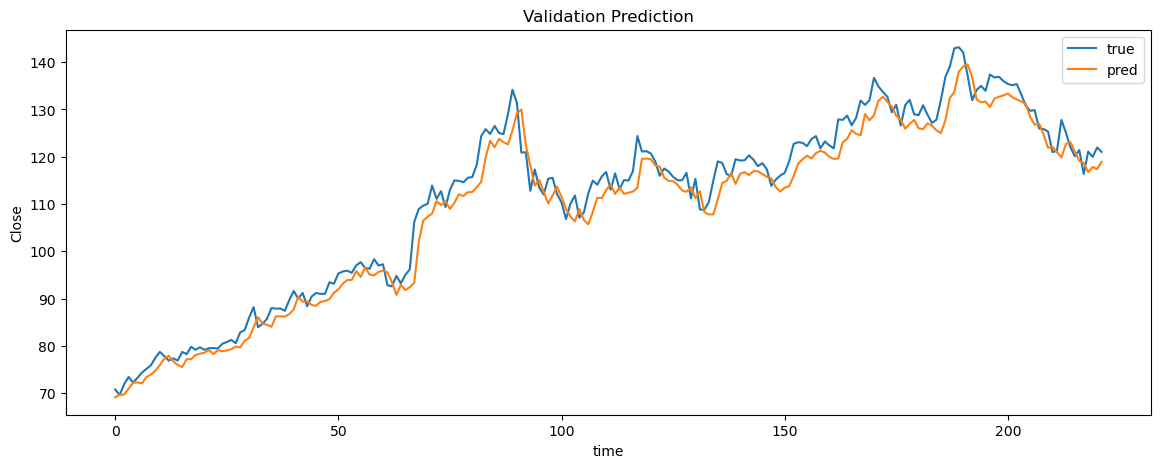

In [182]:
# lookback size = 60
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=60, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lookback_60 = build_rnn_model_relu_64(input_shape)
model_lookback_60.summary()

history_lookback_60 = model_lookback_60.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_lookback_60)
evaluate_model(model_lookback_60, X_train, y_train, X_val, y_val, scaler_target_train_val)

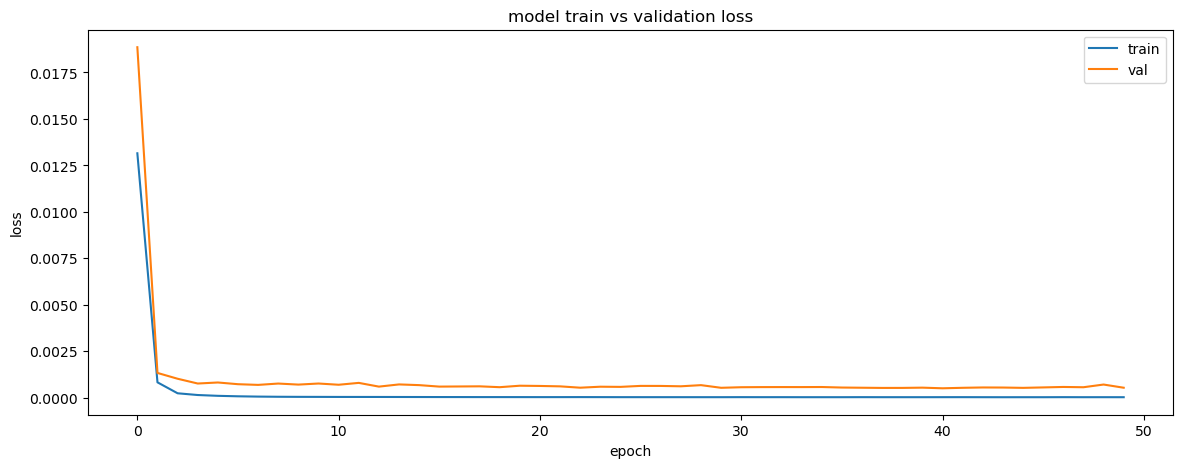

7/7 [==============================] - 0s 1ms/step
Train RMSE: 0.75938470047537
Val RMSE: 3.172875560328743
Train MSE: 0.5766651233160675
Val MSE: 10.067139321331434
Train R2: 0.9976581564857406
Val R2: 0.9715004319169217


<Figure size 1400x500 with 0 Axes>

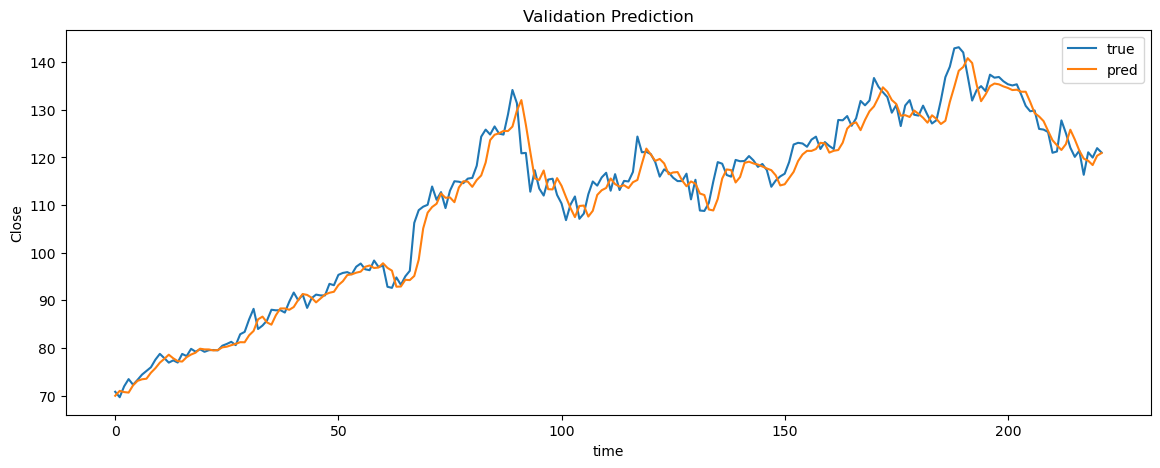

In [184]:
model_lookback_60_ii = build_rnn_model_relu_64(input_shape)
history_lookback_60_ii = model_lookback_60_ii.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=0)
plot_train_val_loss(history_lookback_60_ii)
evaluate_model(model_lookback_60_ii, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 64)                4480      
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


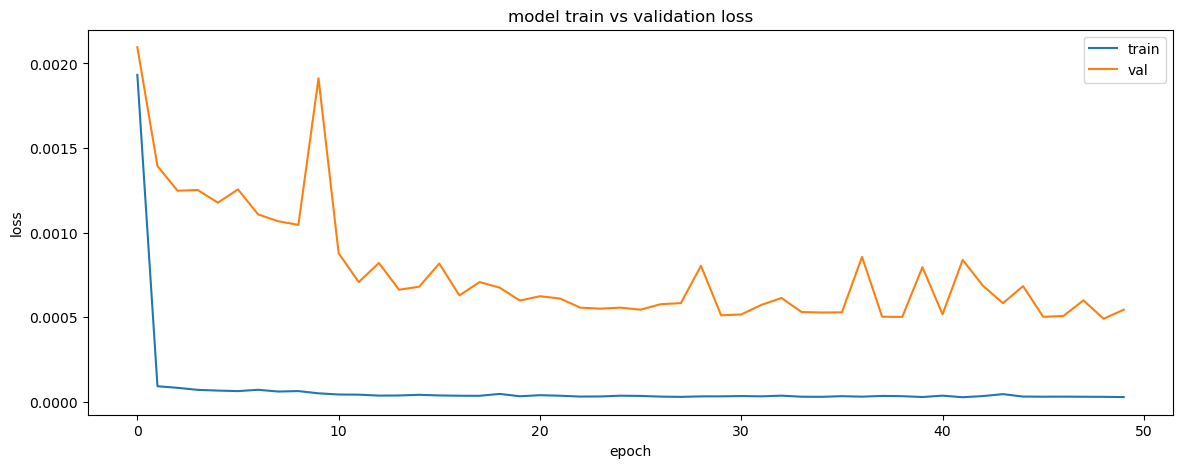

6/6 [==============================] - 0s 2ms/step
Train RMSE: 0.7451994300562956
Val RMSE: 3.1823261609968623
Train MSE: 0.5553221905562279
Val MSE: 10.127199794965028
Train R2: 0.9980087854854944
Val R2: 0.9381347671112749


<Figure size 1400x500 with 0 Axes>

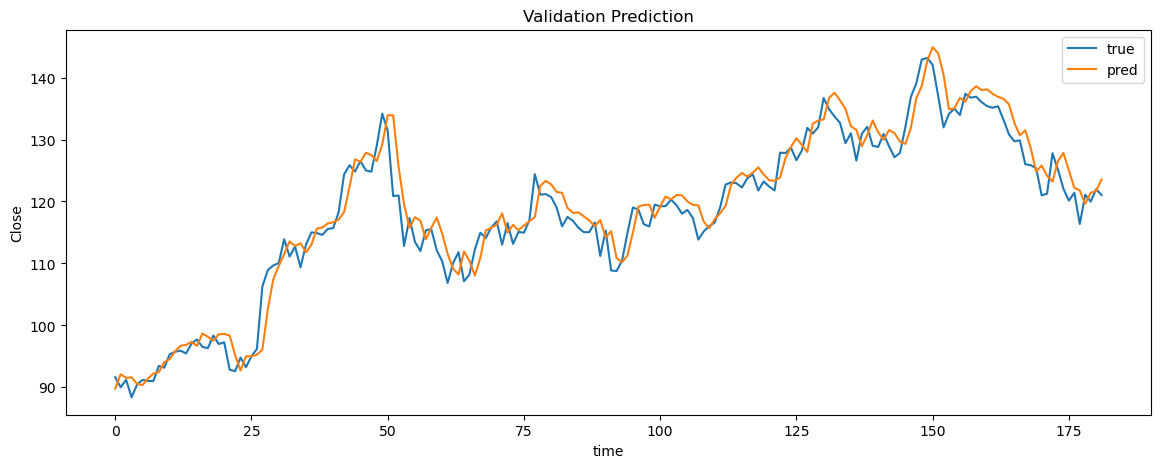

In [46]:
# lookback size = 100
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=100, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lookback_100 = build_rnn_model_relu_64(input_shape)
model_lookback_100.summary()

history_lookback_100 = model_lookback_100.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_lookback_100)
evaluate_model(model_lookback_100, X_train, y_train, X_val, y_val, scaler_target_train_val)


In [ ]:
# Lookback size = 10
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 64)                4480      
                                                                 
 dense_70 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


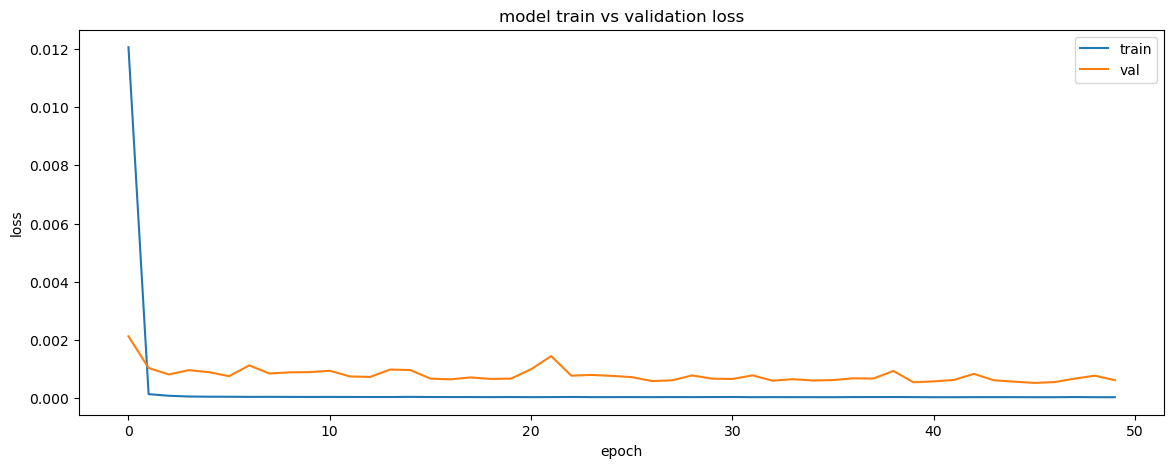

6/6 [==============================] - 0s 2ms/step
Train RMSE: 0.6989246455234611
Val RMSE: 3.380494745829145
Train MSE: 0.4884956601200958
Val MSE: 11.427744726578457
Train R2: 0.998248404862536
Val R2: 0.9301899732190365


<Figure size 1400x500 with 0 Axes>

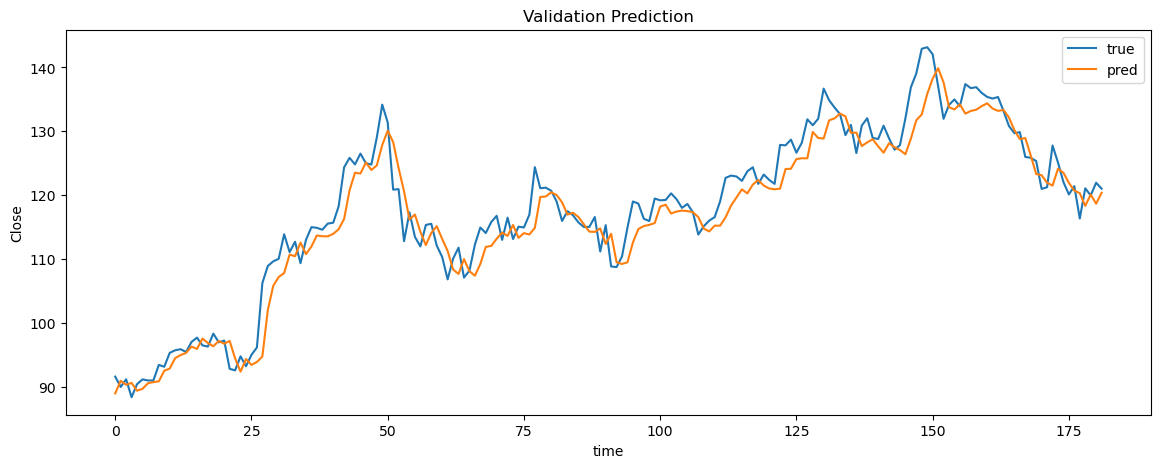

In [154]:
# Lookback size = 100
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=100, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lookback_100 = build_rnn_model_relu_64(input_shape)
model_lookback_100.summary()

history_lookback_100 = model_lookback_100.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
plot_train_val_loss(history_lookback_100)
evaluate_model(model_lookback_100, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 30)                4320      
                                                                 
 dense_48 (Dense)            (None, 1)                 31        
                                                                 
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________


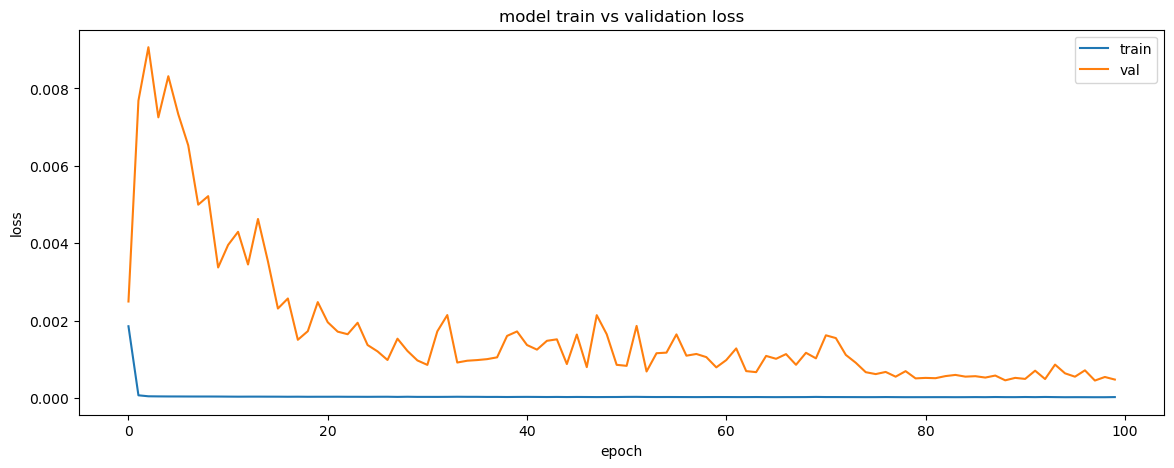

9/9 [==============================] - 0s 593us/step
Train RMSE: 0.5477938193684294
Val RMSE: 2.967291540213653
Train MSE: 0.30007806853825153
Val MSE: 8.804819084623512
Train R2: 0.9986567720393392
Val R2: 0.9844935108620577


<Figure size 1400x500 with 0 Axes>

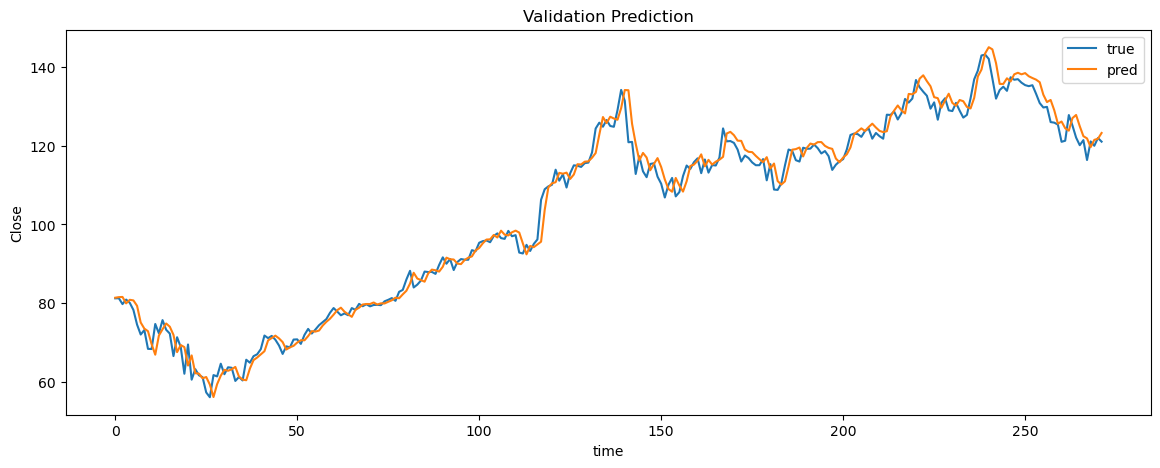

In [118]:
# LSTM
def lstm(input_shape):
    model = Sequential()
    model.add(LSTM(30, activation='relu', input_shape=input_shape))  # Single LSTM layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm = lstm((X_train.shape[1], X_train.shape[2]))
model_lstm.summary()

history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm)
evaluate_model(model_lstm, X_train, y_train, X_val, y_val, scaler_target_train_val)


22/22 [==============================] - 0s 562us/step
Test RMSE: 5.074884784332163
Test MSE: 25.754455574246098
Test R2: 0.9761739768314229


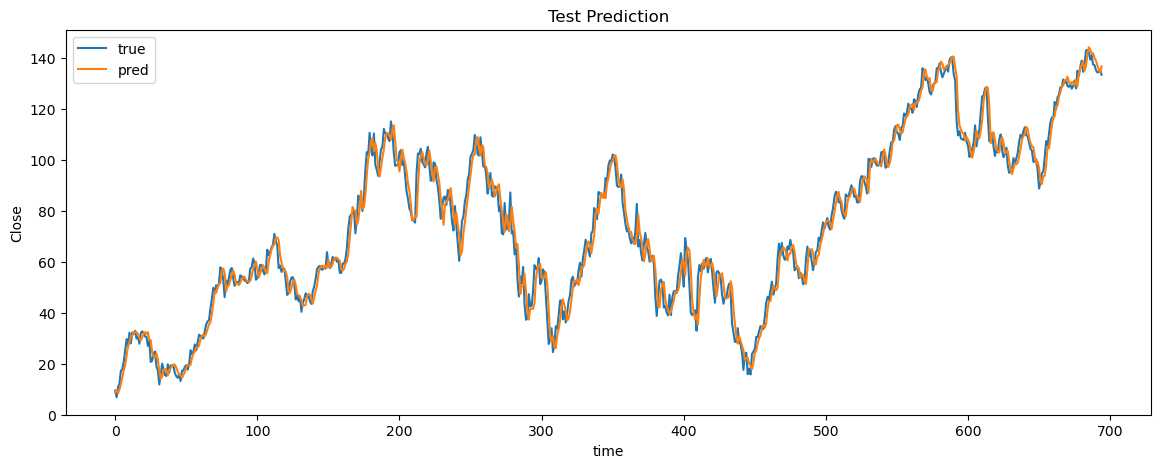

In [119]:
# predict
y_test_pred = model_lstm.predict(X_test)
y_test_pred = scaler_target_train_val.inverse_transform(y_test_pred)
y_test_inv = scaler_target_train_val.inverse_transform(y_test.reshape(-1, 1))
test_mse = mean_squared_error(y_test_inv, y_test_pred)
test_rmse = np.sqrt(test_mse)
r2_test = r2_score(y_test_inv, y_test_pred)
print(f'Test RMSE: {test_rmse}')
print(f'Test MSE: {test_mse}')
print(f'Test R2: {r2_test}')

plot_prediction(y_test_inv, y_test_pred, title='Test Prediction')

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30)                4320      
                                                                 
 dense_49 (Dense)            (None, 16)                496       
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


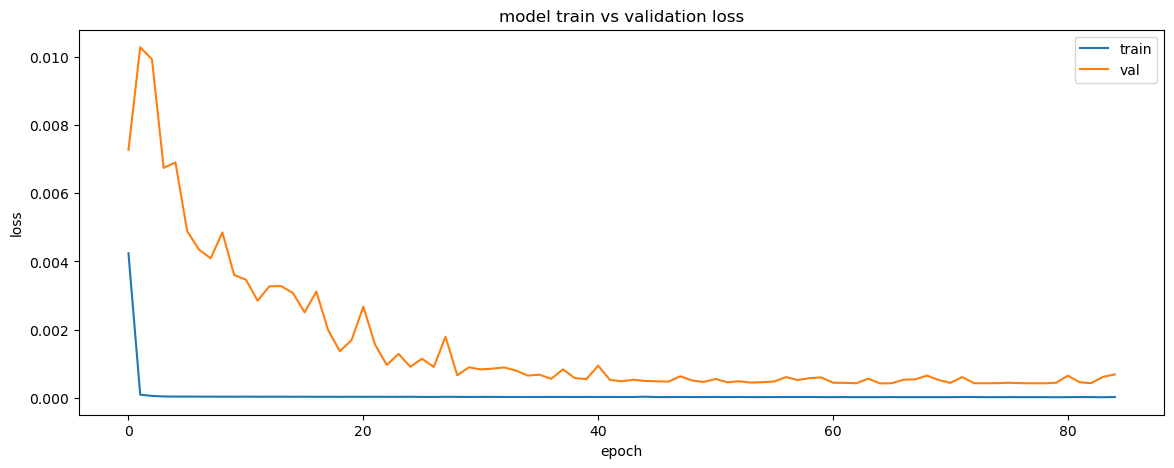

9/9 [==============================] - 0s 592us/step
Train RMSE: 0.5794462958197059
Val RMSE: 2.802986101163837
Train MSE: 0.3357580097391781
Val MSE: 7.856731083317648
Train R2: 0.9984970592856239
Val R2: 0.9861632233402774


<Figure size 1400x500 with 0 Axes>

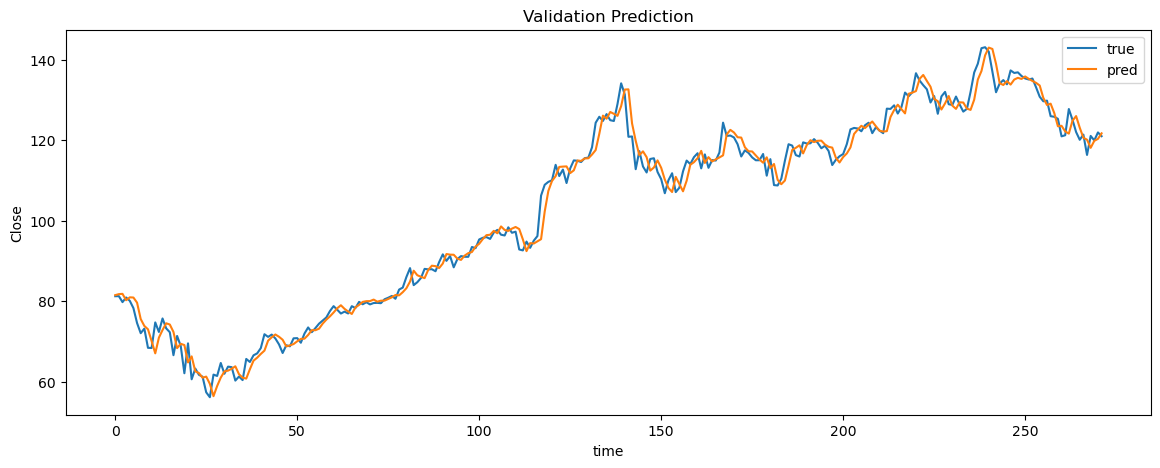

In [ ]:
# LSTM
def lstm(input_shape):
    model = Sequential()
    model.add(LSTM(60, activation='relu', input_shape=input_shape))  # Single LSTM layer
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm = lstm((X_train.shape[1], X_train.shape[2]))
model_lstm.summary()

history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm)
evaluate_model(model_lstm, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60)                15840     
                                                                 
 dense_84 (Dense)            (None, 16)                976       
                                                                 
 dense_85 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


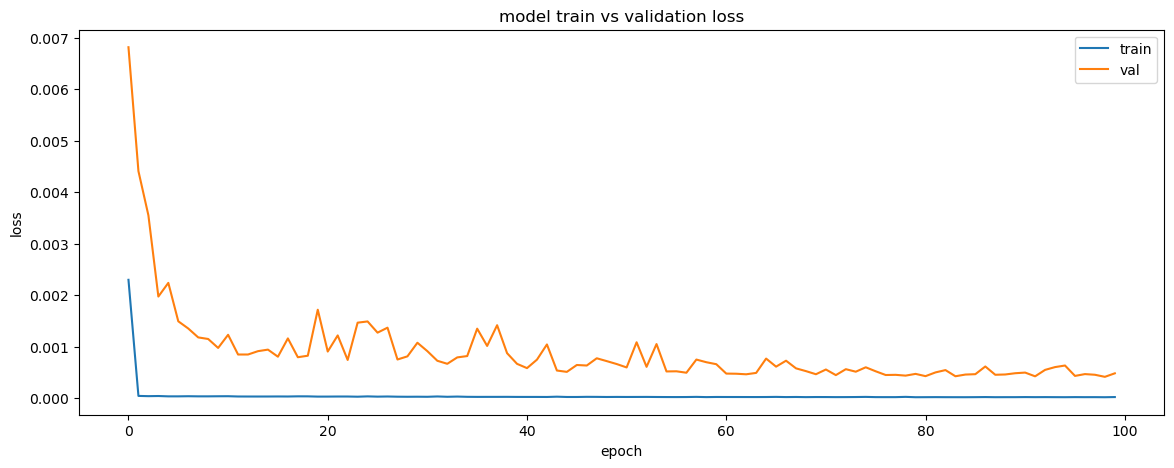

9/9 [==============================] - 0s 754us/step
Train RMSE: 0.5699505201703572
Val RMSE: 2.9926314636550564
Train MSE: 0.3248435954424607
Val MSE: 8.955843077258205
Train R2: 0.9985459150601528
Val R2: 0.9842275369812942


<Figure size 1400x500 with 0 Axes>

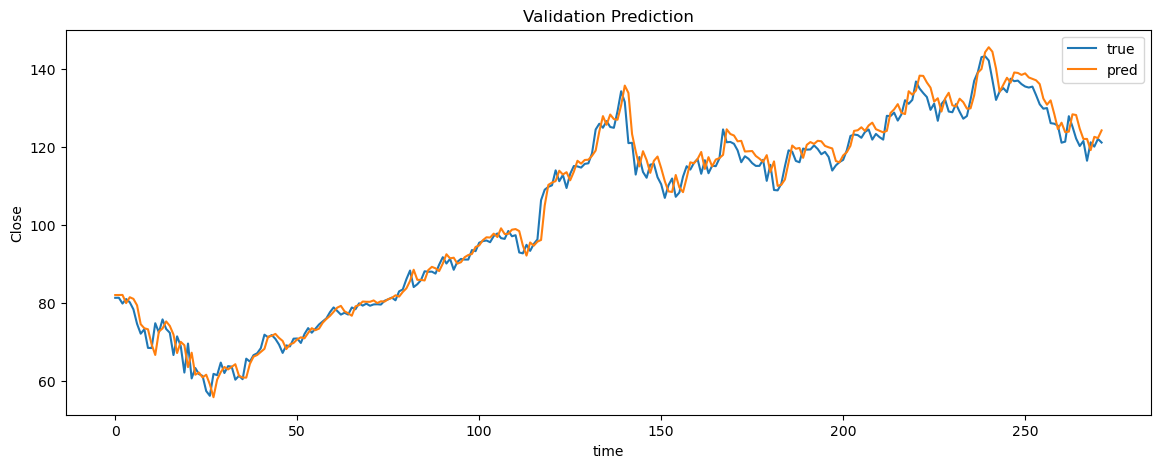

In [164]:
# lstm with 60 unit
def lstm(input_shape):
    model = Sequential()
    model.add(LSTM(60, activation='relu', input_shape=input_shape))  # Single LSTM layer
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm_3= lstm((X_train.shape[1], X_train.shape[2]))
model_lstm_3.summary()

history_lstm_3 = model_lstm_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm_3)
evaluate_model(model_lstm_3, X_train, y_train, X_val, y_val, scaler_target_train_val)


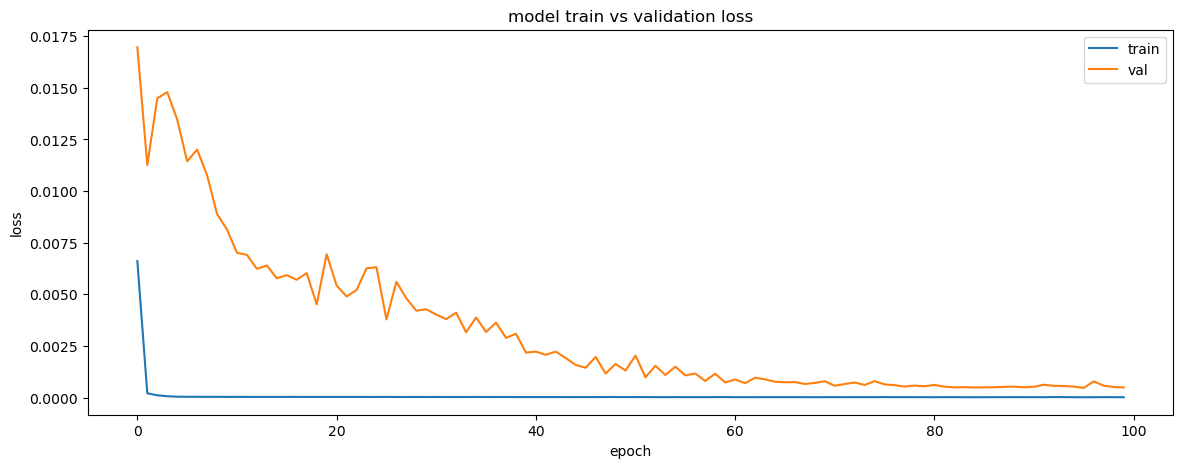

9/9 [==============================] - 0s 732us/step
Train RMSE: 0.6026840017598369
Val RMSE: 3.018474033255813
Train MSE: 0.36322800597725113
Val MSE: 9.111185489439617
Train R2: 0.9983740963939804
Val R2: 0.9839539577738168


<Figure size 1400x500 with 0 Axes>

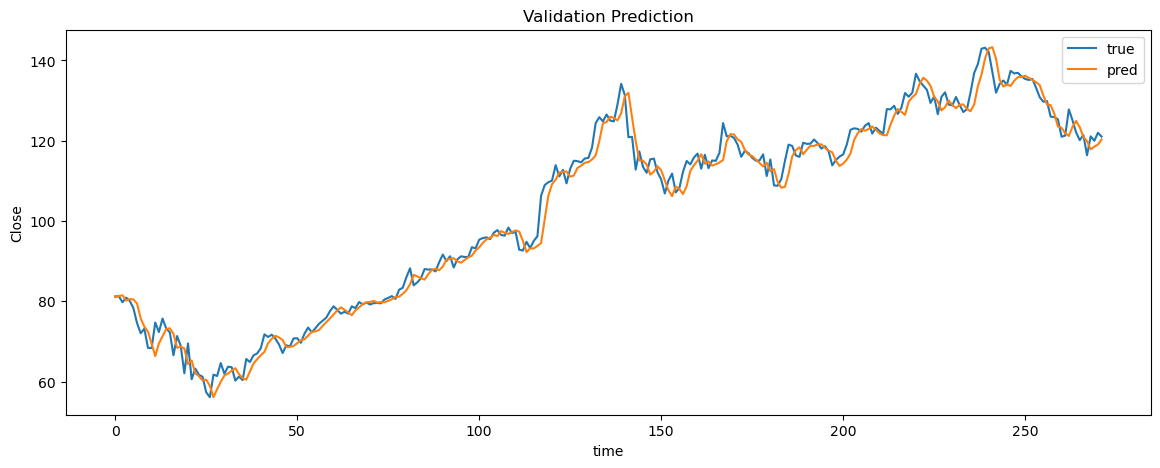

In [209]:
# model lstm with batch size 64
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)
model_lstm_bs64 = lstm((X_train.shape[1], X_train.shape[2]))
history_lstm_bs64 = model_lstm_bs64.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm_bs64)
evaluate_model(model_lstm_bs64, X_train, y_train, X_val, y_val, scaler_target_train_val)


9/9 [==============================] - 0s 580us/step
Train RMSE: 0.5794462958197059
Val RMSE: 2.802986101163837
Train MSE: 0.3357580097391781
Val MSE: 7.856731083317648
Train R2: 0.9984970592856239
Val R2: 0.9861632233402774


<Figure size 1400x500 with 0 Axes>

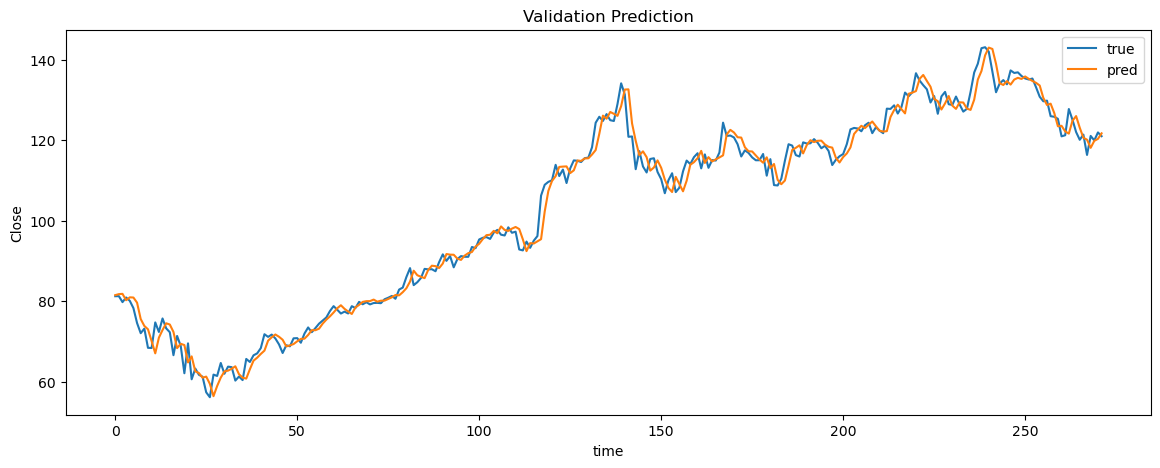

In [121]:
evaluate_model(model_lstm, X_train, y_train, X_val, y_val, scaler_target_train_val)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 60)               8640      
 nal)                                                            
                                                                 
 dense_51 (Dense)            (None, 1)                 61        
                                                                 
Total params: 8,701
Trainable params: 8,701
Non-trainable params: 0
_________________________________________________________________


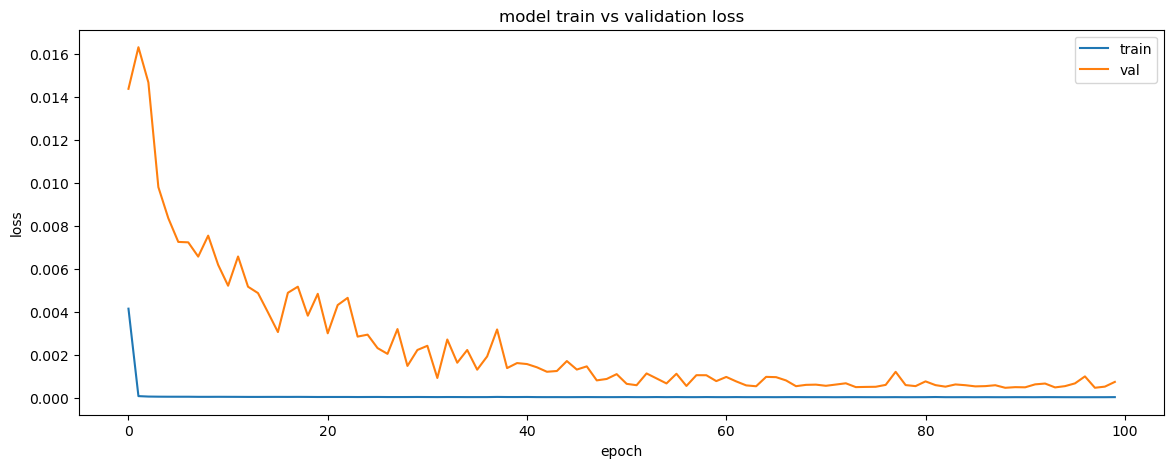

9/9 [==============================] - 0s 816us/step
Train RMSE: 0.6016313789069352
Val RMSE: 3.6871536334607895
Train MSE: 0.3619603160854602
Val MSE: 13.5951019167431
Train R2: 0.9983797709056714
Val R2: 0.9760571684466122


<Figure size 1400x500 with 0 Axes>

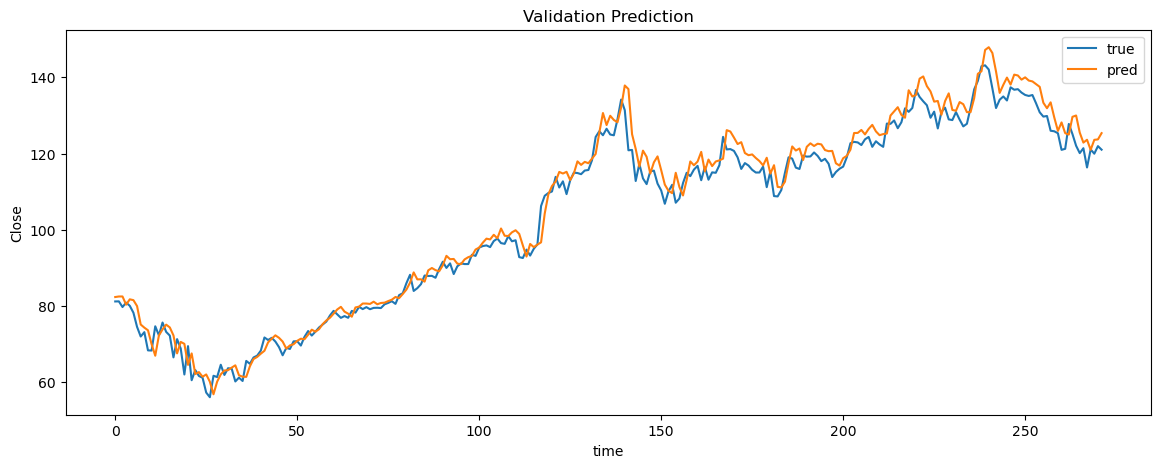

In [122]:
# Bi-directional LSTM
from tensorflow.keras.layers import Bidirectional

def bidirectional_lstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(30, activation='relu'), input_shape=input_shape))  # Single Bi-LSTM layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_bidirectional_lstm = bidirectional_lstm((X_train.shape[1], X_train.shape[2]))
model_bidirectional_lstm.summary()

history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_bidirectional_lstm)
evaluate_model(model_bidirectional_lstm, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 30)                4320      
                                                                 
 dense_62 (Dense)            (None, 16)                496       
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


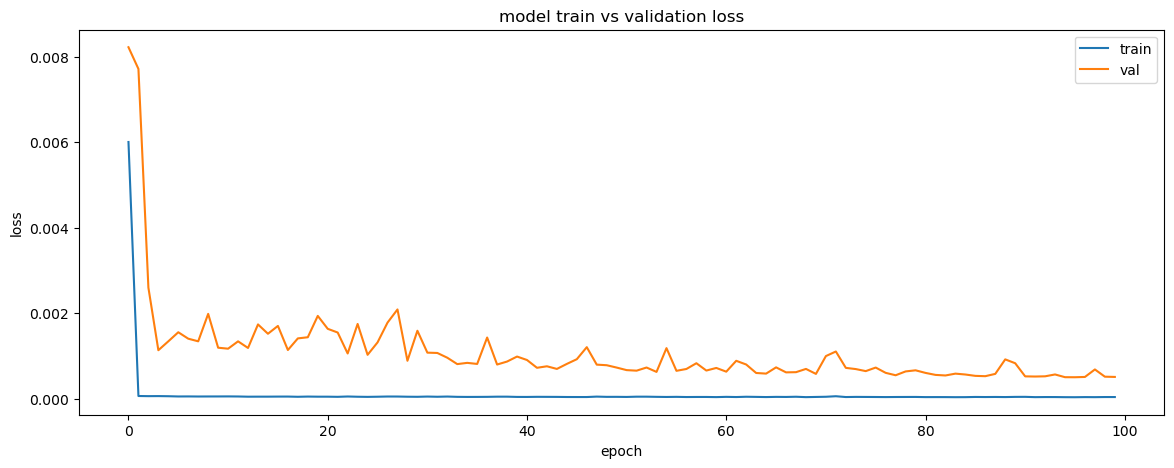

6/6 [==============================] - 0s 2ms/step
Train RMSE: 0.8253067366980227
Val RMSE: 3.0662696844449044
Train MSE: 0.6811312096391394
Val MSE: 9.402009777745853
Train R2: 0.9975576730518229
Val R2: 0.9425648218363873


<Figure size 1400x500 with 0 Axes>

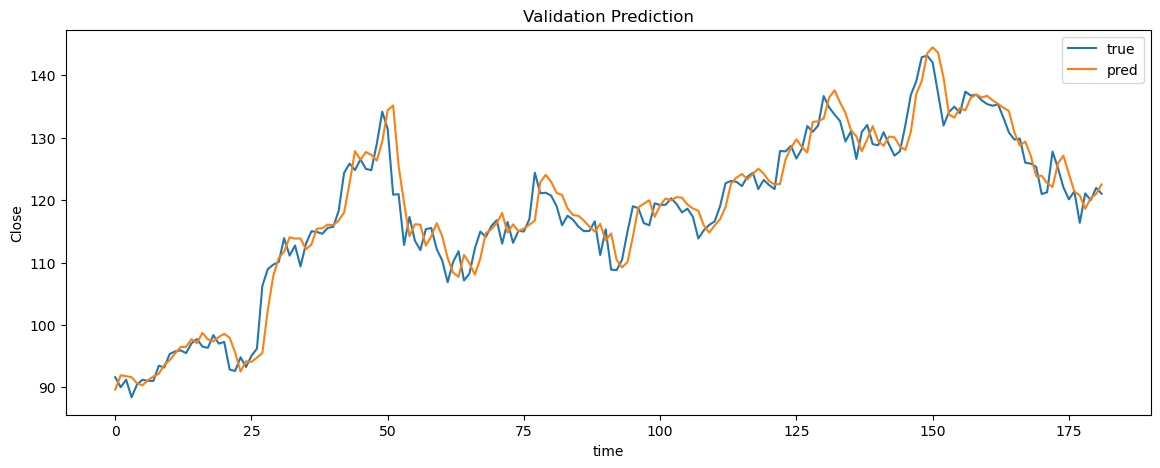

In [139]:
# Model LSTM with 100 lookback
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=100, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lstm_100 = lstm(input_shape)
model_lstm_100.summary()

history_lstm_100 = model_lstm_100.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm_100)
evaluate_model(model_lstm_100, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 60)                15840     
                                                                 
 dense_99 (Dense)            (None, 16)                976       
                                                                 
 dense_100 (Dense)           (None, 1)                 17        
                                                                 
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


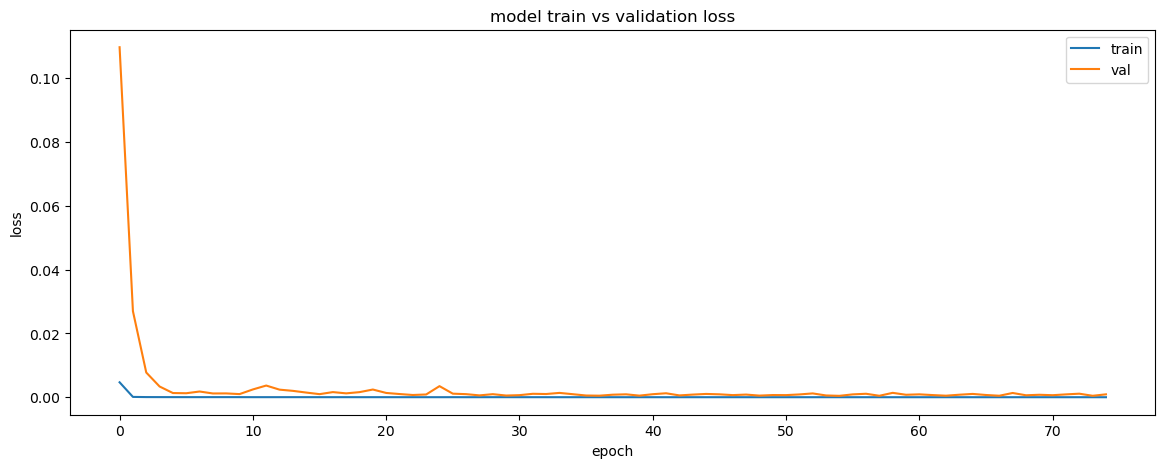

8/8 [==============================] - 0s 1ms/step
Train RMSE: 0.7271780557313817
Val RMSE: 2.9179998262106324
Train MSE: 0.5287879247372725
Val MSE: 8.514722985765282
Train R2: 0.9977608962192228
Val R2: 0.984115625699038


<Figure size 1400x500 with 0 Axes>

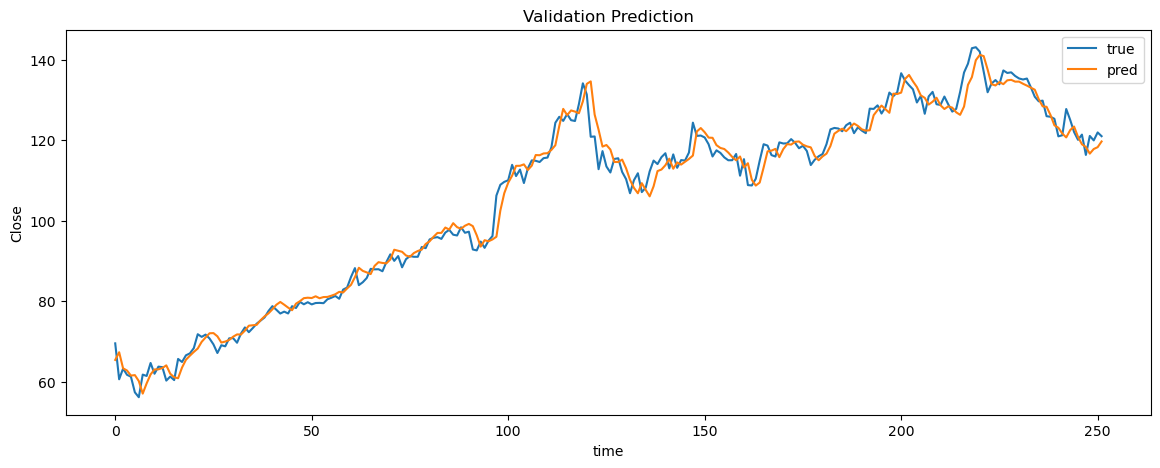

In [200]:
# Lookback size = 30, batch size=32, hidden layer 16
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=30, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lstm_30_16 = lstm(input_shape)
model_lstm_30_16.summary()

history_lstm_30_16 = model_lstm_30_16.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm_30_16)
evaluate_model(model_lstm_30_16, X_train, y_train, X_val, y_val, scaler_target_train_val)



Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60)                15840     
                                                                 
 dense_88 (Dense)            (None, 16)                976       
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


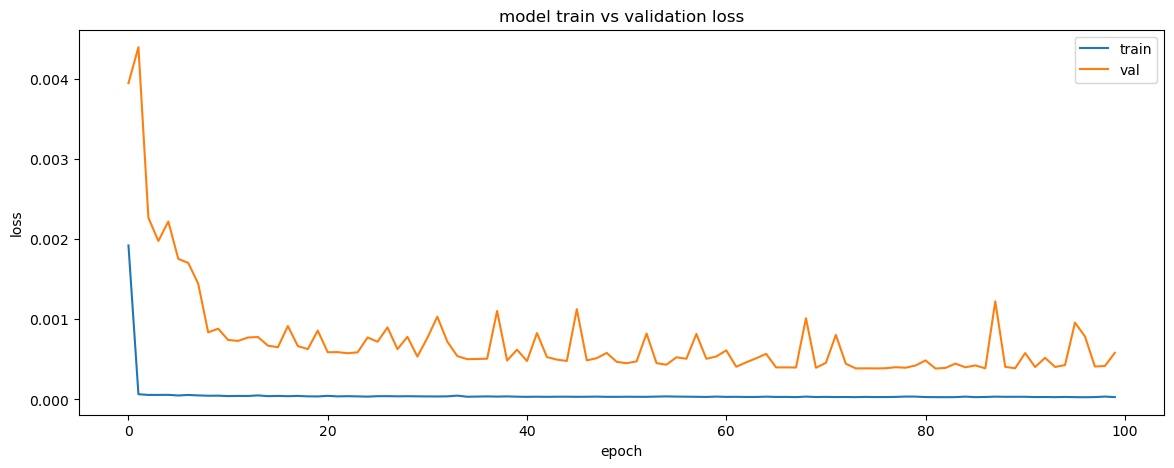

7/7 [==============================] - 0s 2ms/step
Train RMSE: 0.9293884632838109
Val RMSE: 3.2881522127715326
Train MSE: 0.8637629156850434
Val MSE: 10.811944974354326
Train R2: 0.9964922491405015
Val R2: 0.9693919243519167


<Figure size 1400x500 with 0 Axes>

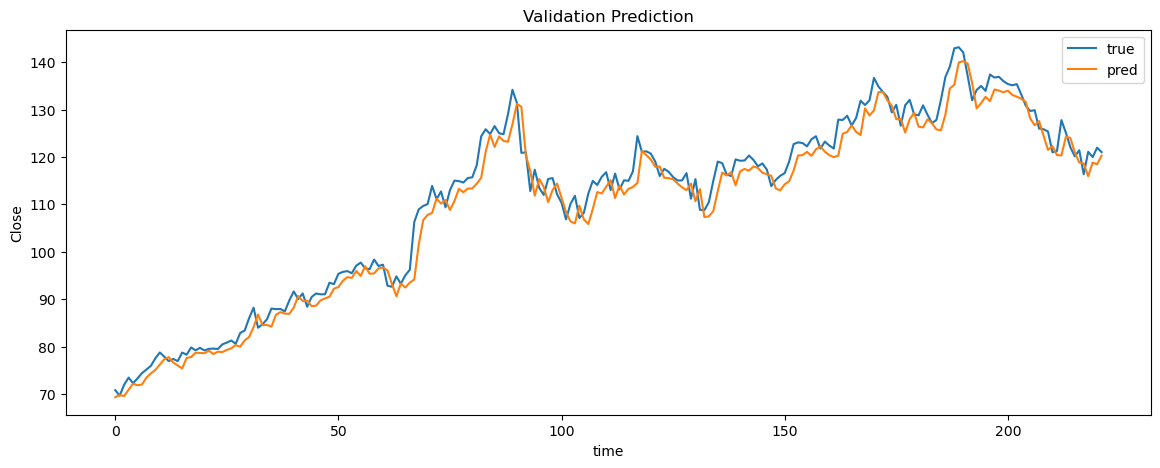

In [178]:
# Lookback size = 60, batch size=32, hidden layer 16
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=60, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_lstm_60_16 = lstm(input_shape)
model_lstm_60_16.summary()

history_lstm_60_16 = model_lstm_60_16.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_lstm_60_16)
evaluate_model(model_lstm_60_16, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 60)                12060     
                                                                 
 dense_72 (Dense)            (None, 1)                 61        
                                                                 
Total params: 12,121
Trainable params: 12,121
Non-trainable params: 0
_________________________________________________________________


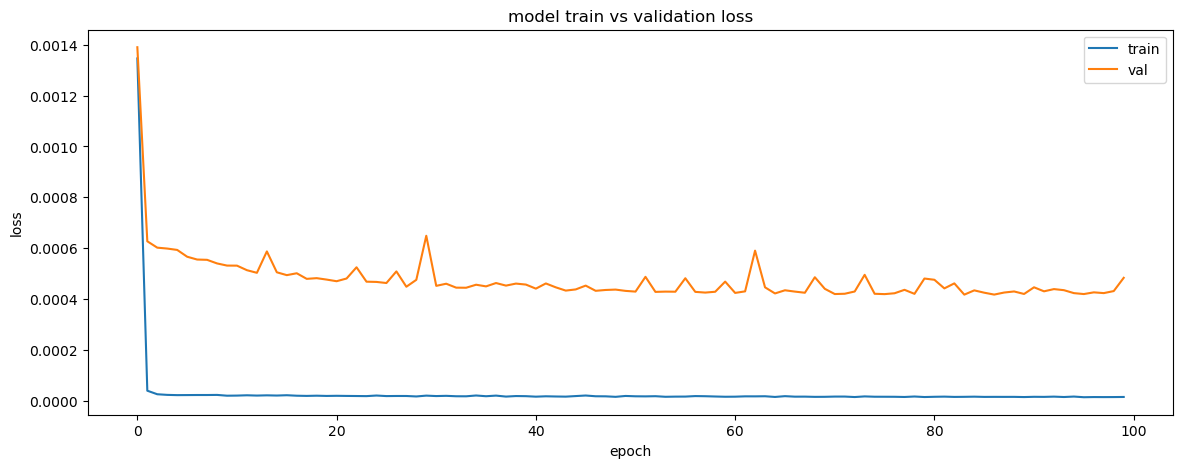

9/9 [==============================] - 0s 626us/step
Train RMSE: 0.6429322235477056
Val RMSE: 2.999229669680509
Train MSE: 0.4133618440759969
Val MSE: 8.995378611491855
Train R2: 0.9981496842153847
Val R2: 0.9841579095049923


<Figure size 1400x500 with 0 Axes>

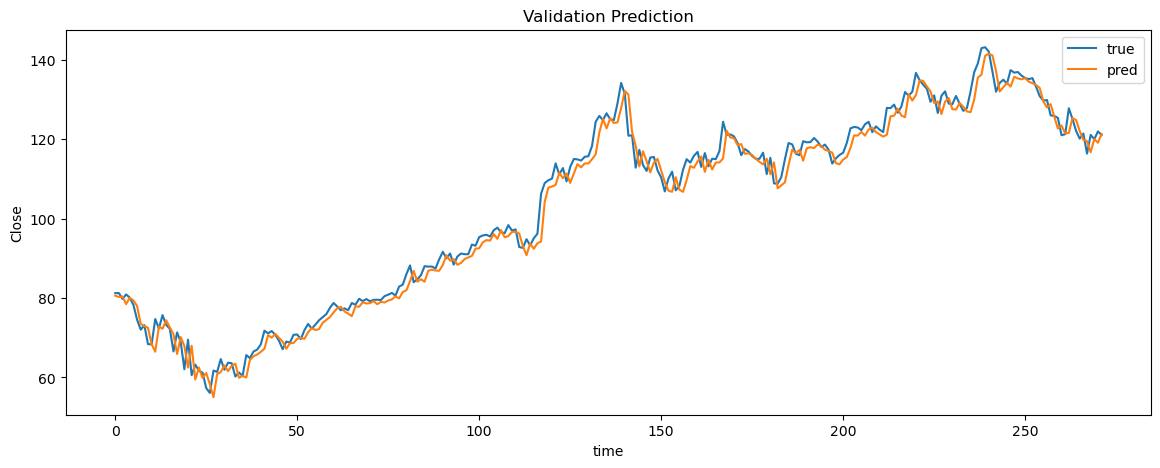

In [ ]:
from tensorflow.keras.layers import GRU

# GRU model
def gru(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(60, activation='relu', input_shape=input_shape))  # Single GRU layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model_gru = gru((X_train.shape[1], X_train.shape[2]))
model_gru.summary()

history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru)
evaluate_model(model_gru, X_train, y_train, X_val, y_val, scaler_target_train_val)

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 60)                12060     
                                                                 
 dense_73 (Dense)            (None, 16)                976       
                                                                 
 dense_74 (Dense)            (None, 1)                 17        
                                                                 
Total params: 13,053
Trainable params: 13,053
Non-trainable params: 0
_________________________________________________________________


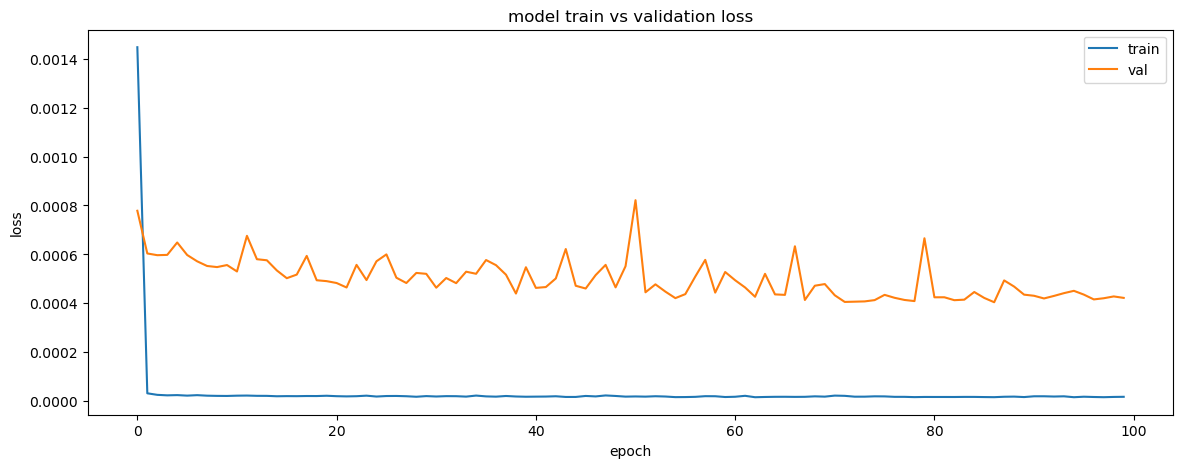

9/9 [==============================] - 0s 706us/step
Train RMSE: 0.6411972251440553
Val RMSE: 2.800657802440812
Train MSE: 0.4111338815324363
Val MSE: 7.843684126372598
Train R2: 0.9981596571587538
Val R2: 0.9861862008136596


<Figure size 1400x500 with 0 Axes>

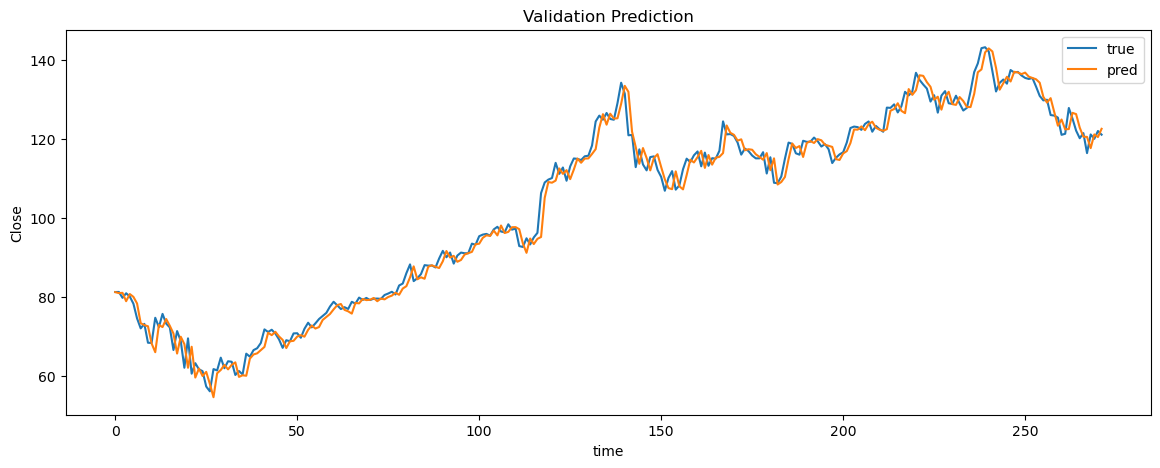

In [159]:
def gru_2(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(60, activation='relu', input_shape=input_shape))  # First GRU layer
    model.add(Dense(16, activation='relu'))  # Dense hidden layer
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model_gru_2 = gru_2((X_train.shape[1], X_train.shape[2]))
model_gru_2.summary()

history_gru_2 = model_gru_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru_2)
evaluate_model(model_gru_2, X_train, y_train, X_val, y_val, scaler_target_train_val)

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 50)                8550      
                                                                 
 dense_78 (Dense)            (None, 32)                1632      
                                                                 
 dense_79 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,215
Trainable params: 10,215
Non-trainable params: 0
_________________________________________________________________


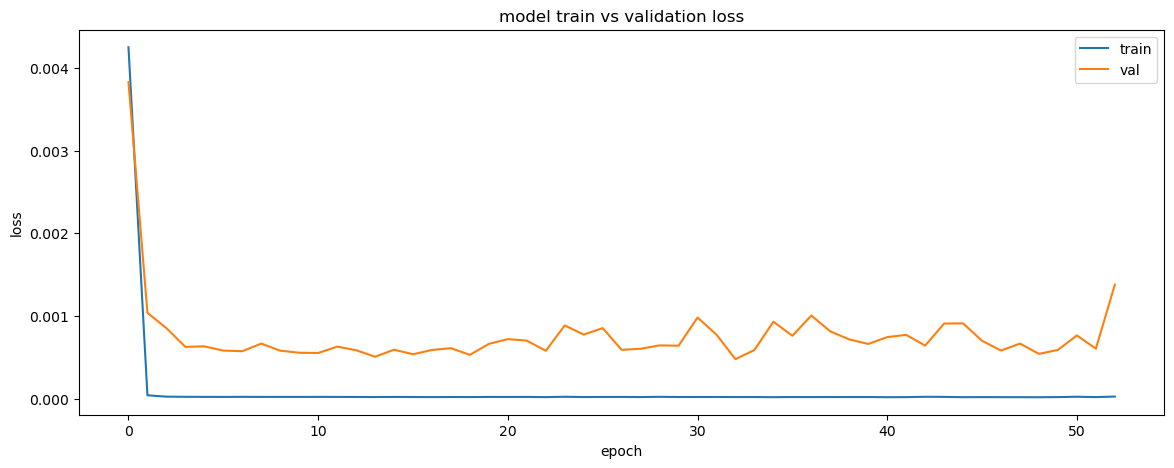

9/9 [==============================] - 0s 632us/step
Train RMSE: 0.6627287318892396
Val RMSE: 2.9799742676598266
Train MSE: 0.4392093720715197
Val MSE: 8.88024663591472
Train R2: 0.9980339839161704
Val R2: 0.9843606726409021


<Figure size 1400x500 with 0 Axes>

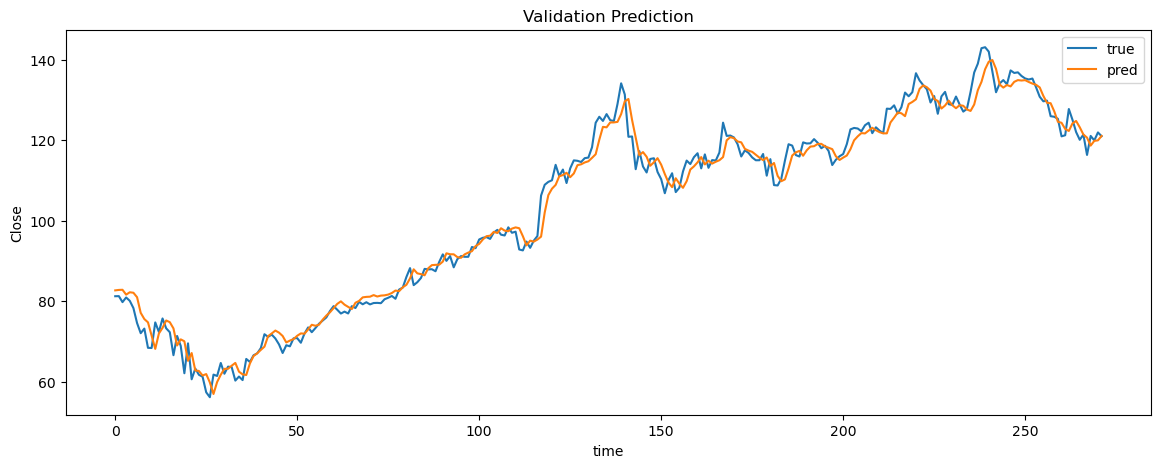

In [161]:
def gru_2(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=input_shape))  # First GRU layer
    model.add(Dense(32, activation='relu'))  # Dense hidden layer 
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model_gru_2 = gru_2((X_train.shape[1], X_train.shape[2]))
model_gru_2.summary()

history_gru_2 = model_gru_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru_2)
evaluate_model(model_gru_2, X_train, y_train, X_val, y_val, scaler_target_train_val)

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 60)                12060     
                                                                 
 dense_101 (Dense)           (None, 16)                976       
                                                                 
 dense_102 (Dense)           (None, 1)                 17        
                                                                 
Total params: 13,053
Trainable params: 13,053
Non-trainable params: 0
_________________________________________________________________


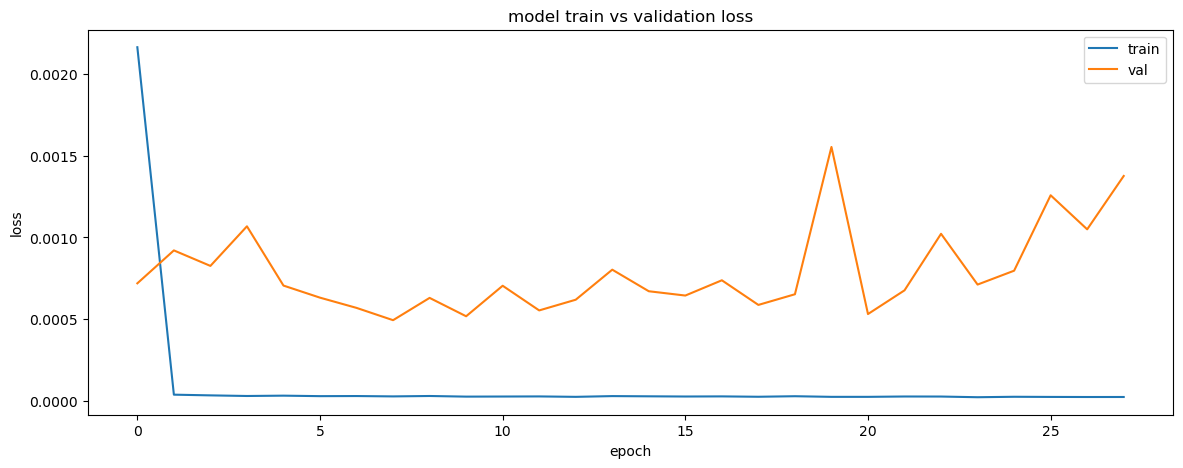

8/8 [==============================] - 0s 1ms/step
Train RMSE: 0.7498539761090528
Val RMSE: 3.030797508996774
Train MSE: 0.5622809854865559
Val MSE: 9.18573354054105
Train R2: 0.9976190729372506
Val R2: 0.9828638430127694


<Figure size 1400x500 with 0 Axes>

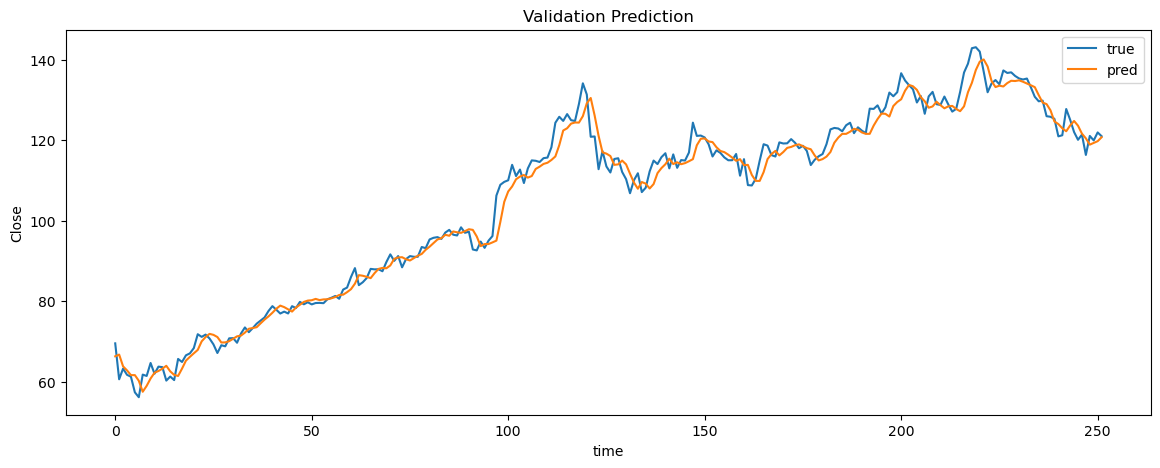

In [201]:
# lookback size = 30, batch size=32, hidden layer 16

def gru_2(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(GRU(60, activation='relu', input_shape=input_shape))  # First GRU layer
    model.add(Dense(16, activation='relu'))  # Dense hidden layer
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=30, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_gru_30_16 = gru_2(input_shape)
model_gru_30_16.summary()

history_gru_30_16 = model_gru_30_16.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru_30_16)
evaluate_model(model_gru_30_16, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_26 (GRU)                (None, 60)                12060     
                                                                 
 dense_94 (Dense)            (None, 16)                976       
                                                                 
 dense_95 (Dense)            (None, 1)                 17        
                                                                 
Total params: 13,053
Trainable params: 13,053
Non-trainable params: 0
_________________________________________________________________


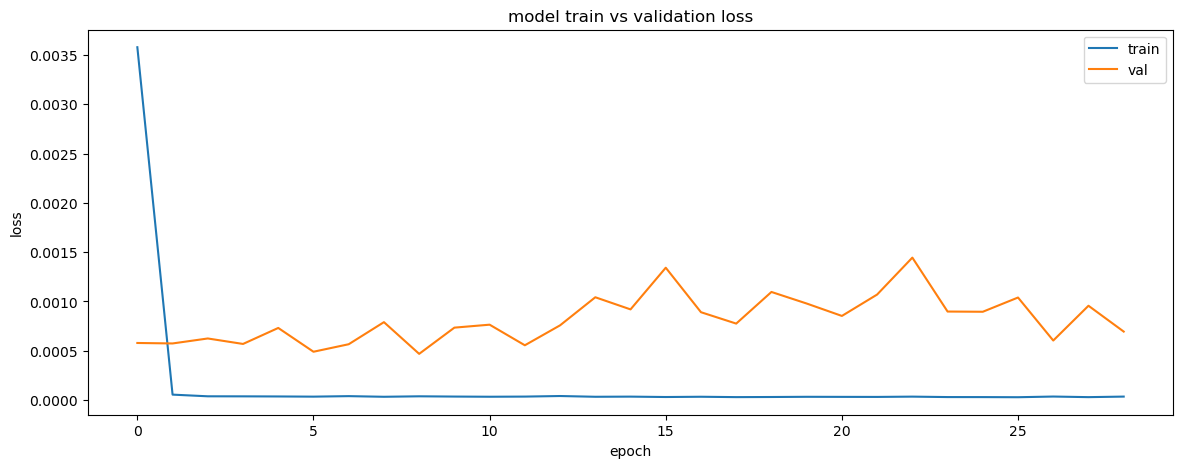

7/7 [==============================] - 0s 2ms/step
Train RMSE: 0.7887181189932736
Val RMSE: 2.949877828219804
Train MSE: 0.6220762712282877
Val MSE: 8.701779201422788
Train R2: 0.9974737413062656
Val R2: 0.9753656981512734


<Figure size 1400x500 with 0 Axes>

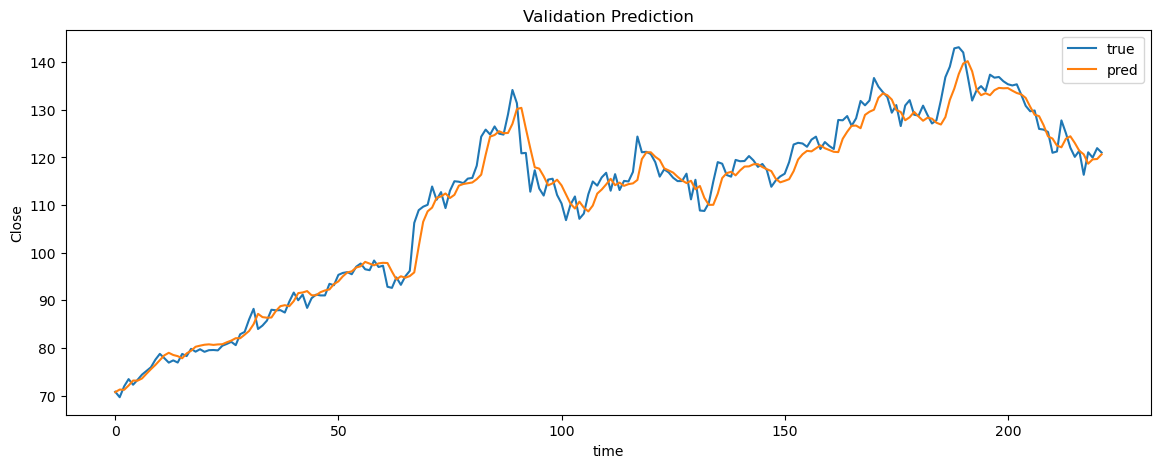

In [181]:
# lookback size = 60, batch size=32, hidden layer 16
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=60, test_size=0.2, val_size=0.1)

input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data for the model
model_gru_60_16 = gru_2(input_shape)
model_gru_60_16.summary()

history_gru_60_16 = model_gru_60_16.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru_60_16)
evaluate_model(model_gru_60_16, X_train, y_train, X_val, y_val, scaler_target_train_val)


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 60)               6660      
 nal)                                                            
                                                                 
 dense_61 (Dense)            (None, 1)                 61        
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


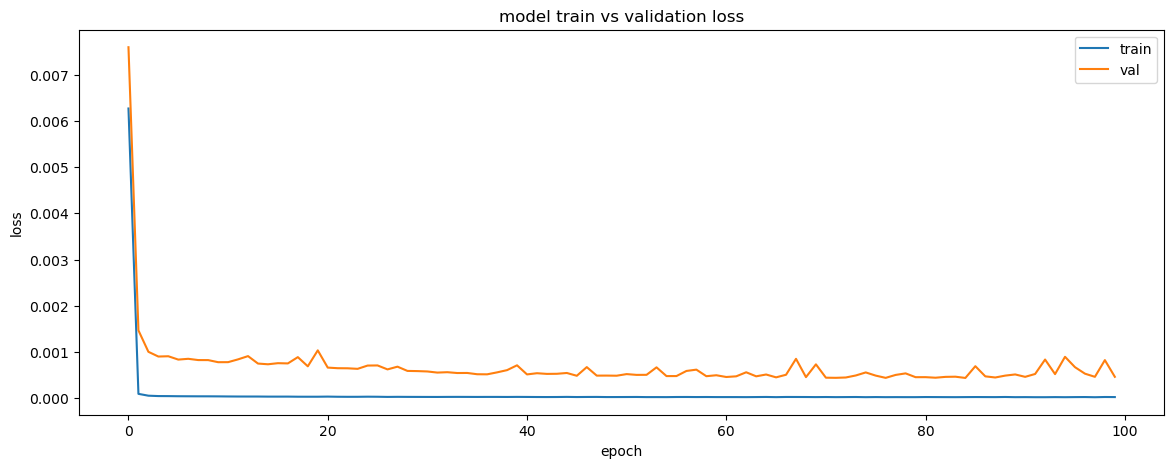

9/9 [==============================] - 0s 810us/step
Train RMSE: 0.5670383579700853
Val RMSE: 2.9178414274535163
Train MSE: 0.32153249940941053
Val MSE: 8.513798595763975
Train R2: 0.9985607363924605
Val R2: 0.9850060376960615


<Figure size 1400x500 with 0 Axes>

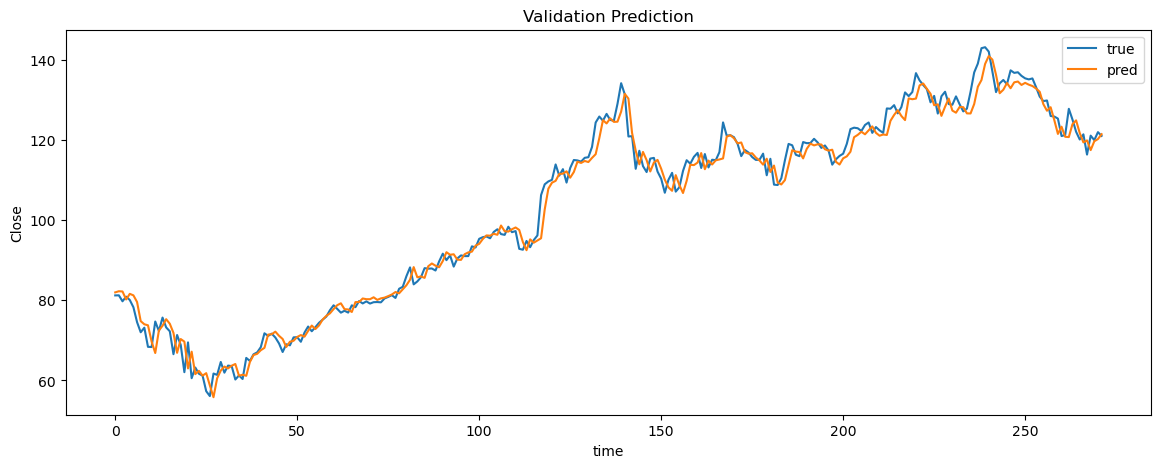

In [137]:
# Bi-directional GRU
def bidirectional_gru(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Bidirectional(GRU(30, activation='relu'), input_shape=input_shape))  # Single Bi-GRU layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model_bidirectional_gru = bidirectional_gru((X_train.shape[1], X_train.shape[2]))
model_bidirectional_gru.summary()

history_bidirectional_gru = model_bidirectional_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_bidirectional_gru)
evaluate_model(model_bidirectional_gru, X_train, y_train, X_val, y_val, scaler_target_train_val)


In [155]:
# lookback size = 10
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)

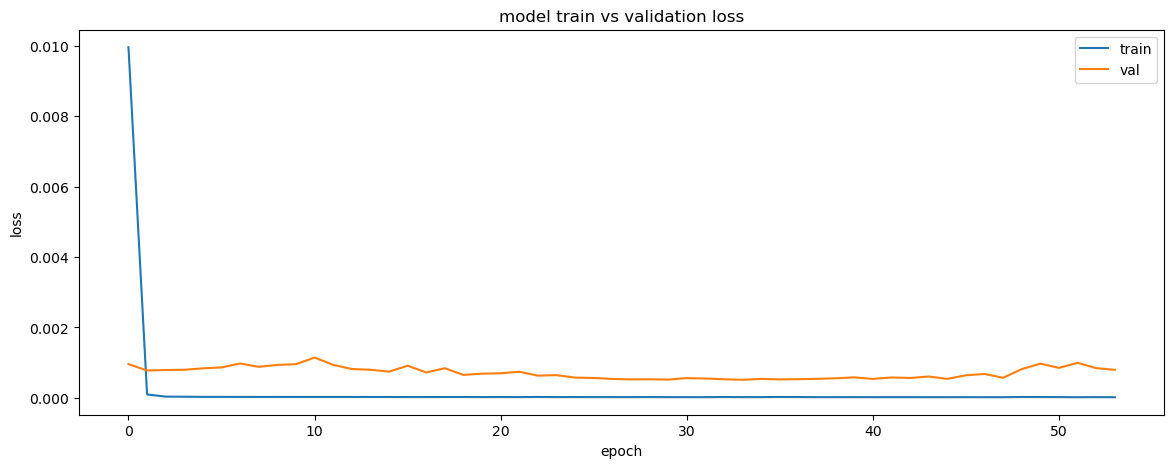

9/9 [==============================] - 0s 660us/step
Train RMSE: 0.5855986125096723
Val RMSE: 3.086288447349066
Train MSE: 0.34292573497325335
Val MSE: 9.525176380240309
Train R2: 0.9984649746717911
Val R2: 0.9832248632643544


<Figure size 1400x500 with 0 Axes>

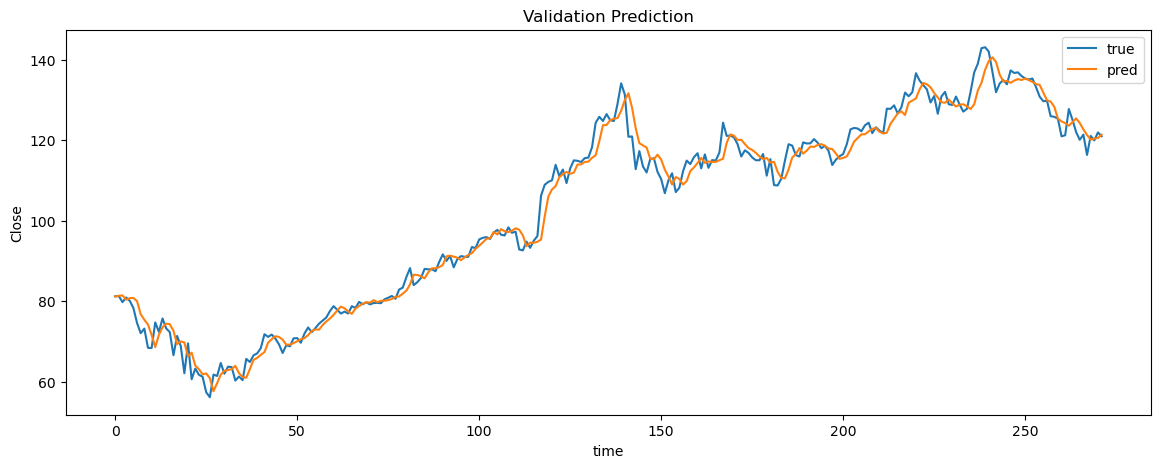

In [210]:
# GRU with batch size = 64
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)

model_gru_bs64 = gru((X_train.shape[1], X_train.shape[2]))
history_gru_bs64 = model_gru_bs64.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0, callbacks=[early_stopping])
plot_train_val_loss(history_gru_bs64)
evaluate_model(model_gru_bs64, X_train, y_train, X_val, y_val, scaler_target_train_val)


# SUMMARY

9/9 [==============================] - 0s 717us/step


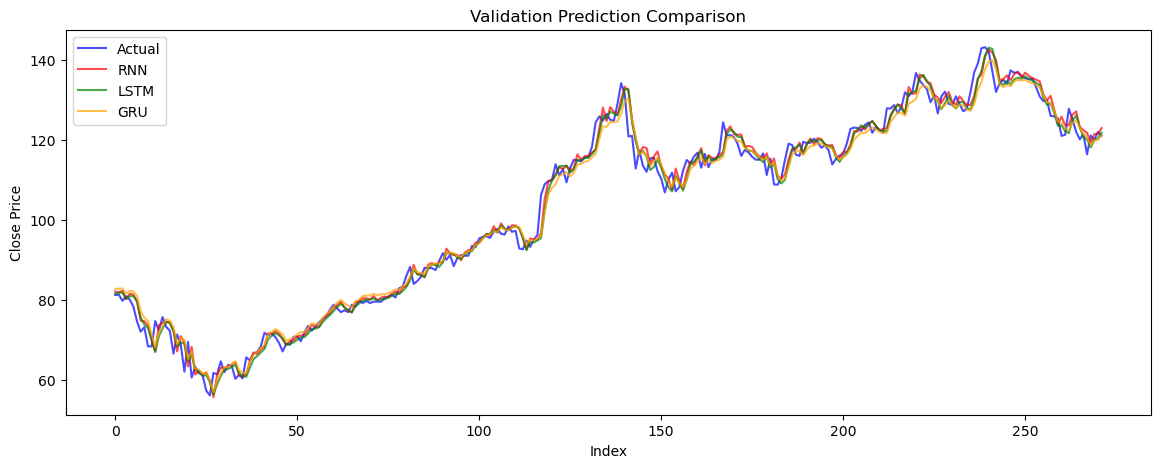

In [186]:
# LOOKBACK SIZE = 10
X_train, X_val, X_test, y_train, y_val, y_test, scaler_features_train_val, scaler_target_train_val, scaler_features_test, scaler_target_test= load_stock_data(apple_data, sequence_length=10, test_size=0.2, val_size=0.1)

y_val_pred_rnn = vanilla_rnn_relu_64.predict(X_val)
y_val_pred_lstm = model_lstm.predict(X_val)
y_val_pred_gru = model_gru_2.predict(X_val)

y_val_pred_rnn = scaler_target_train_val.inverse_transform(y_val_pred_rnn)
y_val_pred_lstm = scaler_target_train_val.inverse_transform(y_val_pred_lstm)
y_val_pred_gru = scaler_target_train_val.inverse_transform(y_val_pred_gru)

y_val_inv = scaler_target_train_val.inverse_transform(y_val.reshape(-1, 1))

# Plot in one plot
plt.figure(figsize=(14, 5))
plt.plot(y_val_inv, label='Actual', color='blue', alpha=0.7)
plt.plot(y_val_pred_rnn, label='RNN', color='red', alpha=0.7)
plt.plot(y_val_pred_lstm, label='LSTM', color='green', alpha=0.7)
plt.plot(y_val_pred_gru, label='GRU', color='orange', alpha=0.7)
plt.title('Validation Prediction Comparison')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(False)
plt.show()


22/22 [==============================] - 0s 657us/step
Test RMSE: 3.307427271540953
Test MSE: 10.939075156532834


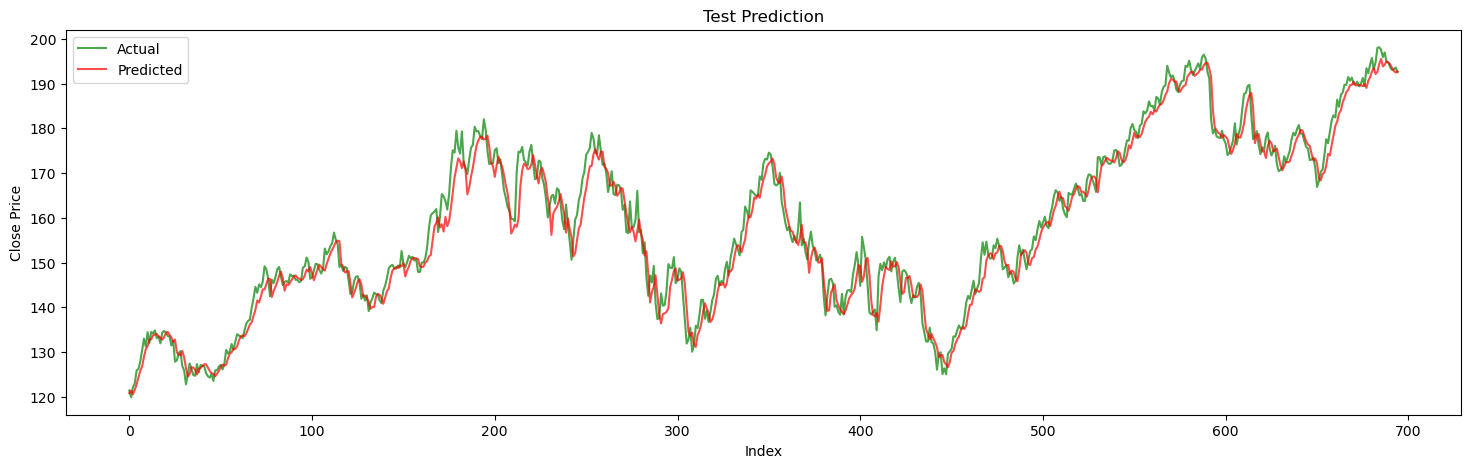

In [194]:
# predict test with gru
y_test_pred = model_gru_2.predict(X_test)
y_test_pred = scaler_target_test.inverse_transform(y_test_pred)
y_test_inv = scaler_target_test.inverse_transform(y_test.reshape(-1, 1))
test_mse = mean_squared_error(y_test_inv, y_test_pred)
test_rmse = np.sqrt(test_mse)
r2_test = r2_score(y_test_inv, y_test_pred)
print(f'Test RMSE: {test_rmse}')
print(f'Test MSE: {test_mse}')

# Plot the prediction (dont use function)
plt.figure(figsize=(18, 5))
plt.plot(y_test_inv, label='Actual', color='green', alpha=0.7)
plt.plot(y_test_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Test Prediction')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(False)
plt.show()


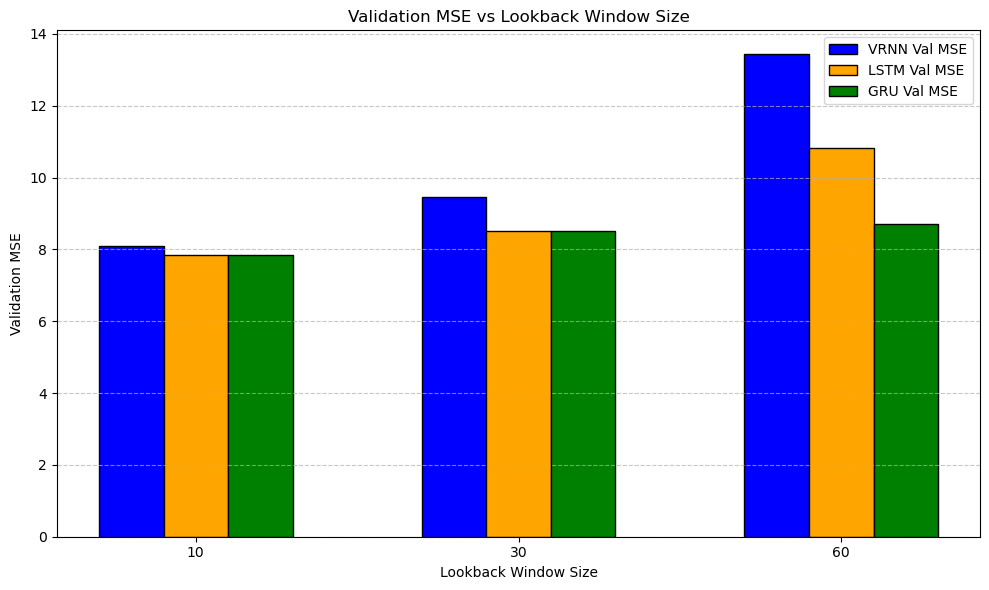

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['VRNN', 'LSTM', 'GRU']
lookback = [10, 30, 60]
val_mse = {
    'VRNN': [8.1, 9.457, 13.43],
    'LSTM': [7.856, 8.51, 10.82],
    'GRU': [7.84, 8.51, 8.7]
}

# X-axis positions
x = np.arange(len(lookback))  # X-axis positions for each lookback window
width = 0.2  # Width of each bar

# Colors for each model
colors = {'VRNN': 'blue', 'LSTM': 'orange', 'GRU': 'green'}

# Plotting Validation MSE
fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models):
    ax.bar(
        x + (i - 1) * width,
        val_mse[model],
        width,
        label=f'{model} Val MSE',
        color=colors[model],
        edgecolor='black'  # Adding border to the bars
    )

# Adding horizontal grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Formatting the plot
ax.set_xlabel('Lookback Window Size')
ax.set_ylabel('Validation MSE')
ax.set_title('Validation MSE vs Lookback Window Size')
ax.set_xticks(x)
ax.set_xticklabels(lookback)
ax.legend()
plt.tight_layout()
plt.show()

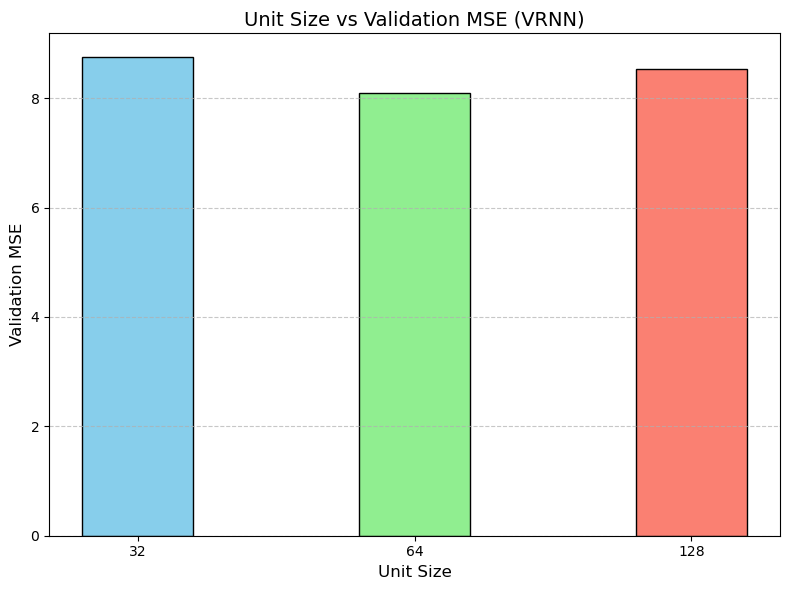

In [208]:
unit_size = ['32', '64', '128']  # Unit sizes as strings for equal spacing
val_mse = [8.747, 8.1, 8.53]    # Corresponding Validation MSE values
colors = ['skyblue', 'lightgreen', 'salmon']  # Different colors for each bar

# Plotting
plt.figure(figsize=(8, 6))
plt.bar([1, 2, 3], val_mse, color=colors, width=0.4, edgecolor='black')
plt.title('Unit Size vs Validation MSE (VRNN)', fontsize=14)
plt.xlabel('Unit Size', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.xticks([1, 2, 3], unit_size, fontsize=10)  # Equal spacing for x-axis
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()